# <span style="color:blue">  AMAZON TIME SERIES ANALYSIS (Aug 22, 2022) </span>


# [Table of Contents]  <a id="Up"></a>
- [sumdata satilan_urun](#sumdata-satilan_urun)
[Data](#Data)
<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Data](#data)<br> 

2. [Sales A](#77) <br>
    2.1 [Naive Forecast](#78) <br>
    2.2 [Moving Average](#79) <br>
    2.3 [Smoothing](#80) <br> 
    2.4 [ARIMA Model](#81) <br> 
        
3. [Sales B](#82) <br>
    3.1. [Check for Stationarity](#83) <br>
    3.2. [Draw auto correlation and partial autocorrelation graphs](#84) <br>
    3.3. [Grid Search Over Parameters](#85) <br>
    3.4. [Create Auto Arima Model](#86) <br> 
    
4. [Sales C](#87) <br> 
    4.1. [Check for Stationarity](#88) <br>
    4.2. [Draw auto correlation and partial autocorrelation graphs](#89) <br>  
    
5. [Sales Total](#90) <br>
    5.1. [Seasonal and Trend Decomposition using Loess (STL)](#91) <br> 
    5.2. [Anomaly Detection](#92) <br>
    5.3. [Simple Exponential Smoothing (SES)](#93) <br>
    5.4. [Holt’s Model](#94) <br>
    5.5. [Holt-Winters’ Seasonal Model](#95) <br> 
 

###  Importing Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import pmdarima as pm
import datetime as dt
import seaborn as sns
#!pip install statsmodels
#!pip install yfinance
#!pip install pmdarima
#!pip install tensorflow --user
#!pip install requests

import requests

from io import BytesIO
from statsmodels.tsa.arima_process import ArmaProcess

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from pmdarima import model_selection
from pandas import DataFrame
from tensorflow.keras.metrics import mse 
from tensorflow.keras.metrics import mae
from IPython.core.pylabtools import figsize
figsize(14, 7)

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
np.random.seed(42)
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from pandas import DataFrame
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.stattools import kpss
from pmdarima import model_selection
from pandas import DataFrame
from IPython.core.pylabtools import figsize
figsize(14, 7)



In [4]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

### Data <a id="data"></a>                  [^](#Up)<br>
**We have daily sales data of Pergamo.**


In [5]:
combined_daily = pd.read_excel('combined_data10.xlsx')


In [6]:
combined_daily.columns

Index(['Unnamed: 0', 'fatura_tarihi', 'Customer', 'posta_kodu', 'city',
       'country', 'COUNTRY NAME', 'satis_yapilan_platform', 'satilan_urun',
       'adet', 'birim_fiyat', 'enflasyon', 'ciro', 'new', 'day_of_week',
       'nakliye', 'category', 'after_covid', 'before_covid', 'after_war',
       'before_war'],
      dtype='object')

In [7]:
del combined_daily['Unnamed: 0']

In [8]:
del combined_daily['new']

In [9]:
combined_daily.columns

Index(['fatura_tarihi', 'Customer', 'posta_kodu', 'city', 'country',
       'COUNTRY NAME', 'satis_yapilan_platform', 'satilan_urun', 'adet',
       'birim_fiyat', 'enflasyon', 'ciro', 'day_of_week', 'nakliye',
       'category', 'after_covid', 'before_covid', 'after_war', 'before_war'],
      dtype='object')

In [121]:
combined_daily.index = pd.to_datetime(combined_daily.fatura_tarihi)
combined_daily.drop(['fatura_tarihi'], axis=1, inplace=True)
combined_daily

,Customer,posta_kodu,city,country,COUNTRY NAME,satis_yapilan_platform,satilan_urun,adet,birim_fiyat,enflasyon,ciro,day_of_week,nakliye,category,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,,,,,,,,,,
2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,almaoliva aove pet 30 ml,20.0,0.500000,1.6,10.000000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,almaoliva aove bio marasca 500 ml,10.0,2.000000,1.6,20.000000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,parqueoliva serie oro aove dop almazaras 500 ml,2.0,4.100000,1.6,8.200000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,royal extra 250 ml,10.0,1.300000,1.6,13.000000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2017-09-01,ID10248,45143,Essen,DEU,GERMANY,ebay,bio lavendel honig - direktimport vom bio erze...,1.0,11.682243,1.3,11.682243,Friday,3.617214,bal,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,IDKundenID3313,1000,other,ATA,ANTARCTICA,wocommerce,dogal findikli muska pestil,1.0,4.210000,7.6,4.210000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0
2022-04-29,IDKundenID3315,1000,other,ATA,ANTARCTICA,wocommerce,dogal findikli muska pestil,1.0,4.200000,7.6,4.200000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0
2022-04-29,IDKundenID7185,1000,other,ATA,ANTARCTICA,wocommerce,gumushane sade ve cevizli dut pestili - 500 gr...,1.0,3.790000,7.6,3.790000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0


In [122]:
combined_daily.ciro.isna().sum()

0

In [12]:
combined_daily.dropna(subset = ['ciro'], inplace = True)

In [13]:
combined_daily[combined_daily.ciro.isna()==True]

,Customer,posta_kodu,city,country,COUNTRY NAME,satis_yapilan_platform,satilan_urun,adet,birim_fiyat,enflasyon,ciro,day_of_week,nakliye,category,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,,,,,,,,,,


In [14]:
combined_daily.shape

(39306, 18)

In [15]:
combined_daily.columns

Index(['Customer', 'posta_kodu', 'city', 'country', 'COUNTRY NAME',
       'satis_yapilan_platform', 'satilan_urun', 'adet', 'birim_fiyat',
       'enflasyon', 'ciro', 'day_of_week', 'nakliye', 'category',
       'after_covid', 'before_covid', 'after_war', 'before_war'],
      dtype='object')

In [208]:
ebay = combined_daily[combined_daily['satis_yapilan_platform']=='ebay']

In [209]:
kaufland = combined_daily[combined_daily['satis_yapilan_platform']=='kaufland']

In [210]:
b2b = combined_daily[combined_daily['satis_yapilan_platform']=='b2b']

In [211]:
amazon = combined_daily[combined_daily['satis_yapilan_platform']=='amazon']

In [212]:
wocommerce = combined_daily[combined_daily['satis_yapilan_platform']=='wocommerce']

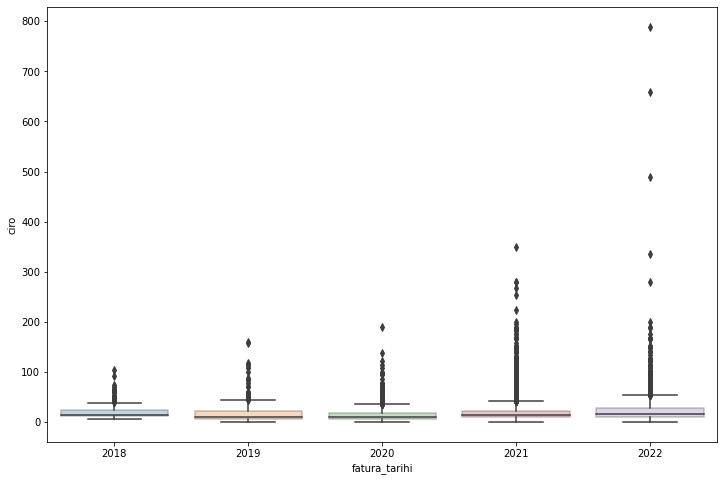

In [213]:
#box plot to see distribution of sales in each year
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data=amazon, x=amazon.index.year, y = 'ciro',  ax = ax, boxprops=dict(alpha=.3));
#sns.swarmplot(data=combined_daily, x=combined_daily.index.year, y = 'ciro');

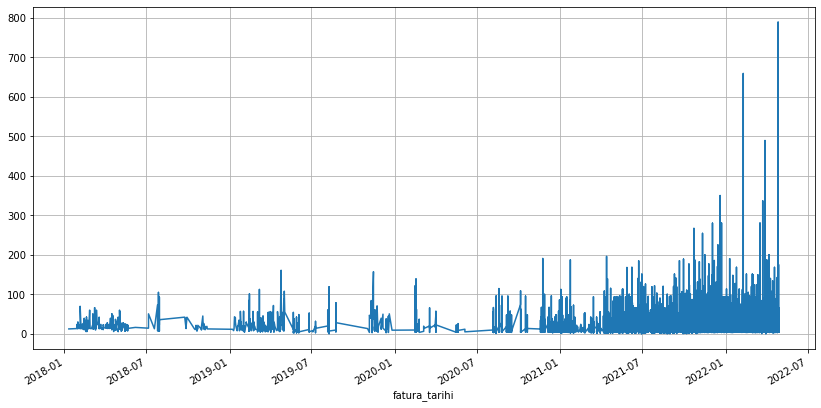

In [214]:
plt.figure(figsize=(14, 7))
amazon.ciro.plot(grid=True)
plt.show()

In [215]:
#%Growth each year. Excluding 2022 since we have only 2 quarters
growth = amazon[:'2022'].groupby(amazon[:'2022'].index.year)["ciro"].sum().pct_change()
growth*100


fatura_tarihi
2018            NaN
2019      44.808167
2020     155.975045
2021    1002.381417
2022     -51.608260
Name: ciro, dtype: float64

**Distribution of Sales in each year**



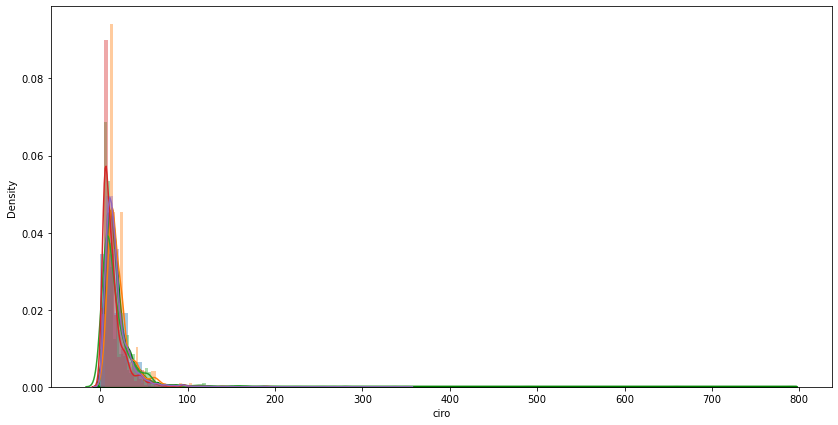

In [216]:
#Distribution plot of each year compared with overall distribution
sns.distplot(amazon.ciro,         label='ciro', hist=True, kde_kws={"color": "g", "lw": 3, "label": "Train","shade":True})
sns.distplot(amazon['2018'].ciro, label='2018', hist=True)
sns.distplot(amazon['2019'].ciro, label='2019', hist=True)
sns.distplot(amazon['2020'].ciro, label='2020', hist=True)
sns.distplot(amazon['2021'].ciro, label='2021', hist=True);


In [218]:
amazon_q = amazon

In [219]:
amazon_q= amazon_q.resample('Q').mean()

In [220]:
amazon_q.index

DatetimeIndex(['2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
               '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
               '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
               '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31',
               '2022-03-31', '2022-06-30'],
              dtype='datetime64[ns]', name='fatura_tarihi', freq='Q-DEC')

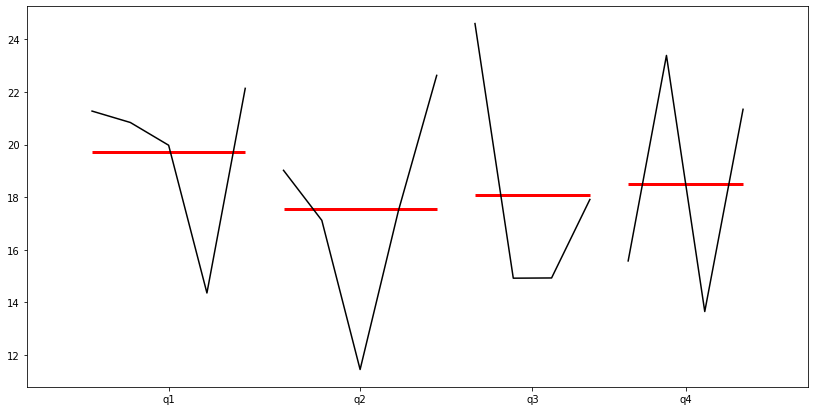

In [221]:
#Quarterly plot: Shows trend for Q1-Q4 for each of the years. Red line shows mean
quarter_plot(amazon_q[['ciro']]);

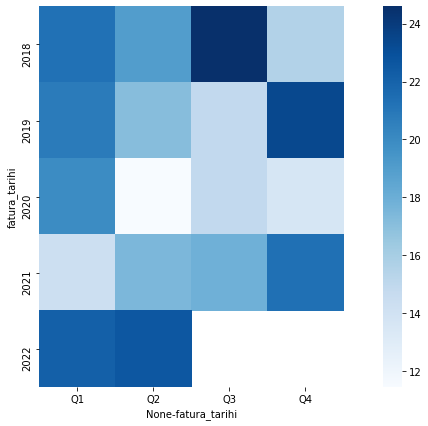

In [222]:
#collapse-hide
sns.heatmap(pd.pivot_table(data=amazon[['ciro']], index=amazon.index.year, columns=amazon.index.quarter),
           square=True,
           cmap='Blues',
           xticklabels=["Q1", "Q2", "Q3", "Q4"]);


**Decomposition**

We will de-compose the time series into trend, seasonal and residuals

additive is prefferred when seasonal variation is constant. multiplicative is preferred when it is increasing.

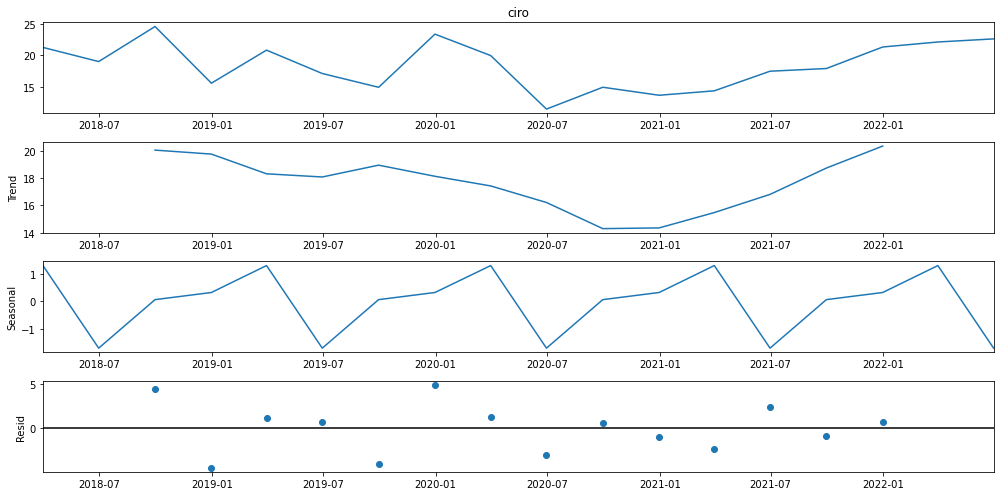

In [224]:
decomposition = sm.tsa.seasonal_decompose(amazon_q.ciro, model = 'additive') 
fig = decomposition.plot();
fig.set_size_inches(14,7)
plt.show()

**Observations:**

 - Trend is more than linear,  notice that trend is projecting downward and then upward.
 - Seasonal pattern is consistent
 - Resduals are whatever is left after fitting the trend and seasonal components to the observed data. It's the component we cannot explain. We want the residuals to be i.i.d (i.e uncorrelated). If the residuals have a pattern, it means there is still some structural information left to be captured. Residuals are showing some wavy pattern, which is not good. Let's perform Ljung Box test to confirm if they are i.i.d as a group.
 - We do not want to see any recognizable patterns in the residuals, e.g. waves, upward/downward slope, funnel pattern etc. 
    

In [225]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung

In [226]:
ljung_p = np.mean(ljung(x=decomposition.resid.dropna())[1]).round(3)
print("Ljung Box, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")


Ljung Box, p value: 0.035 , Residuals are correlated


Residuals are correlated. If the residuals are correlated, we can perform transformations to see if it stabilizes the variance. It's also an indication that we may need to use exogenous variable to fully explain the time series behaviour or use higher order models. 

**Monthly Amazon**

In [291]:
amazon_monthly = amazon

In [292]:
amazon_monthly= amazon_monthly.resample('M').sum()

In [293]:
amazon_monthly.index

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30'],
              dtype='datetime64[ns]', name='fatura_tarihi', freq='M')

In [294]:
amazon[amazon.ciro<0]

,Customer,posta_kodu,city,country,COUNTRY NAME,satis_yapilan_platform,satilan_urun,adet,birim_fiyat,enflasyon,ciro,day_of_week,nakliye,category,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,,,,,,,,,,


In [417]:
amazon_monthly[amazon_monthly.ciro.isna()==True]

,adet,birim_fiyat,enflasyon,ciro,nakliye,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,


In [418]:
amazon_monthly[amazon_monthly.ciro == 0] #no sale on these months

,adet,birim_fiyat,enflasyon,ciro,nakliye,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,
2018-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


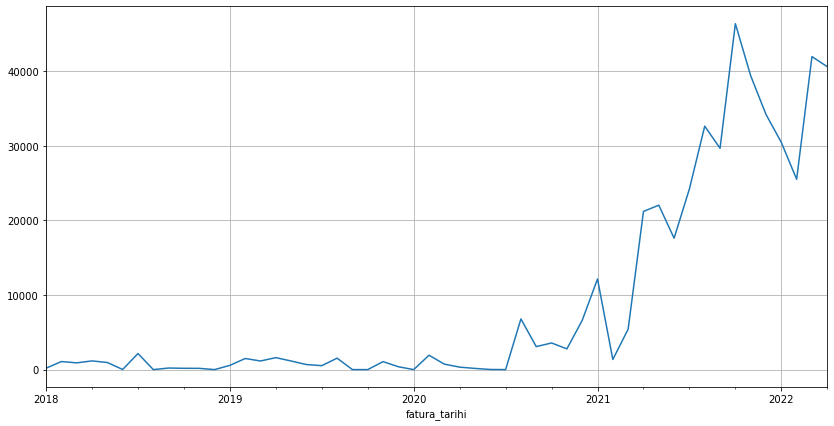

In [301]:
plt.figure(figsize=(14, 7))
amazon_monthly.ciro.plot(grid=True)
plt.show()

In [302]:
#%Growth each year. Excluding 2022 since we have only 2 quarters
growth = amazon_monthly[:'2022'].groupby(amazon_monthly[:'2022'].index.year)["ciro"].sum().pct_change()
growth*100


fatura_tarihi
2018            NaN
2019      44.808167
2020     155.975045
2021    1002.381417
2022     -51.608260
Name: ciro, dtype: float64

**Distribution of Sales in each year**



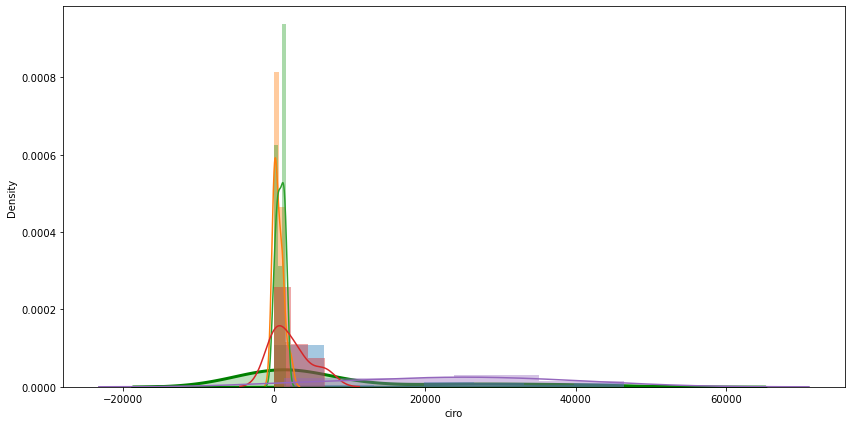

In [303]:
#Distribution plot of each year compared with overall distribution
sns.distplot(amazon_monthly.ciro,         label='ciro', hist=True, kde_kws={"color": "g", "lw": 3, "label": "Train","shade":True})
sns.distplot(amazon_monthly['2018'].ciro, label='2018', hist=True)
sns.distplot(amazon_monthly['2019'].ciro, label='2019', hist=True)
sns.distplot(amazon_monthly['2020'].ciro, label='2020', hist=True)
sns.distplot(amazon_monthly['2021'].ciro, label='2021', hist=True);


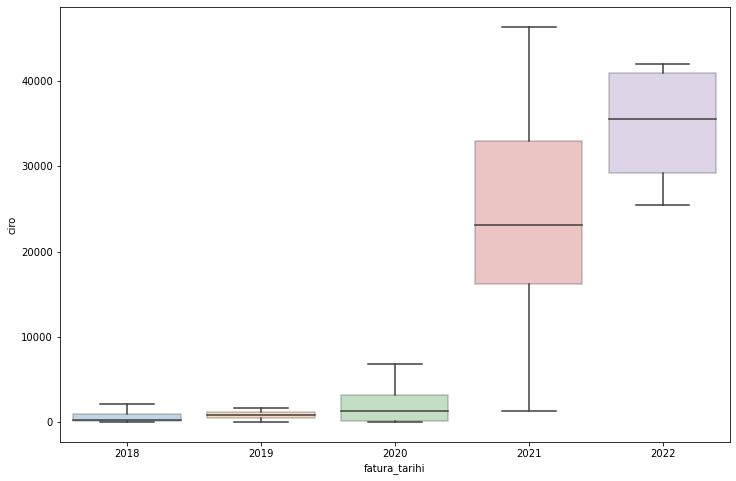

In [300]:
#box plot to see distribution of sales in each year
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data=amazon_monthly, x=amazon_monthly.index.year, y = 'ciro',  ax = ax, boxprops=dict(alpha=.3));
#sns.swarmplot(data=combined_daily, x=combined_daily.index.year, y = 'ciro');

**Decomposition**

We will de-compose the time series into trend, seasonal and residuals

additive is prefferred when seasonal variation is constant. multiplicative is preferred when it is increasing.

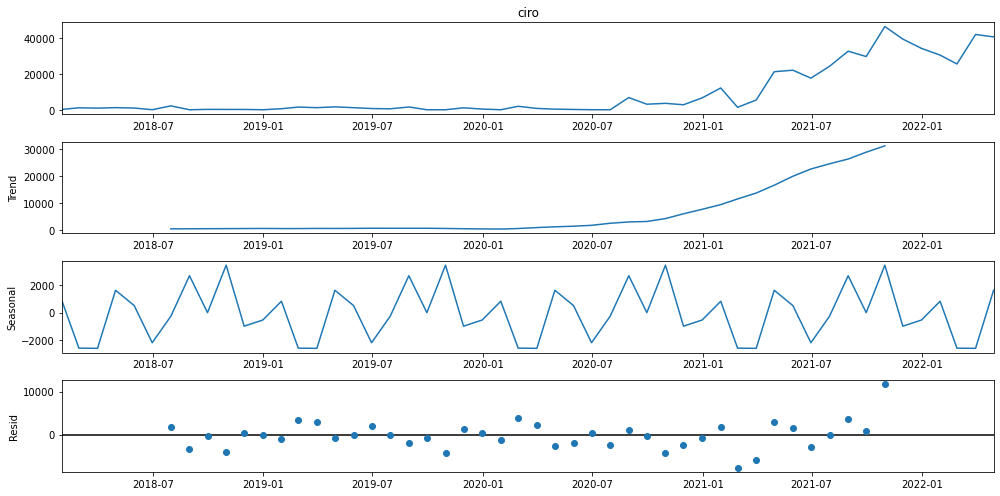

In [296]:
decomposition = sm.tsa.seasonal_decompose(amazon_monthly.ciro, model = 'additive') 
fig = decomposition.plot();
fig.set_size_inches(14,7)
plt.show()

**Observations:**

 - Trend is more than linear,  notice that trend is projecting upward.
 - Seasonal pattern is consistent
 - Resduals are whatever is left after fitting the trend and seasonal components to the observed data. It's the component we cannot explain. We want the residuals to be i.i.d (i.e uncorrelated). If the residuals have a pattern, it means there is still some structural information left to be captured. Residuals are showing some wavy pattern, which is not good. Let's perform Ljung Box test to confirm if they are i.i.d as a group.
 - We do not want to see any recognizable patterns in the residuals, e.g. waves, upward/downward slope, funnel pattern etc. 
    

In [297]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung

In [298]:
ljung_p = np.mean(ljung(x=decomposition.resid.dropna())[1]).round(3)
print("Ljung Box, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")


Ljung Box, p value: 0.849 , Residuals are uncorrelated


Residuals are uncorrelated. If the residuals are correlated, we can perform transformations to see if it stabilizes the variance. It's also an indication that we may need to use exogenous variable to fully explain the time series behaviour or use higher order models. 

**Second Order Properties of the time series**

We study the second order properties to understand -

    is the data stationary
    is the data white noise, random walk? i.e are the lags correlated?
    quantify seasonal/cyclic behviour

Stationarity:

For the series to be stationary, it must have:

    constant mean
    constant variance
    constant covariance (uncorrelated)

We verify this by observing change in mean, variance, autocorrelation and with a statistical test (ADFuller test)


**Is the mean constant?**

Mean is: 19.383473880954973


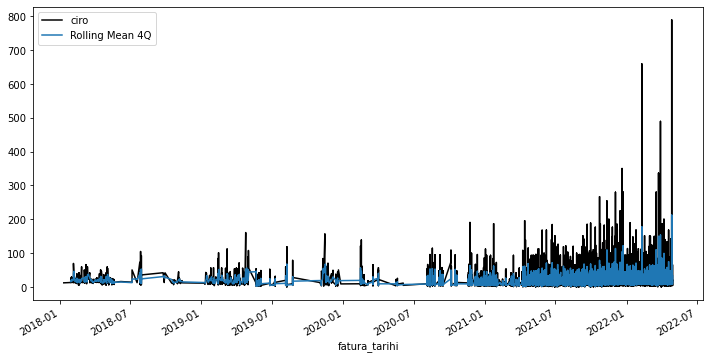

In [305]:
amazon[['ciro']].plot(figsize=(12,6), legend=True, label="amazon", cmap='gray')
amazon["ciro"].rolling(4, center=False).mean().plot(legend=True, label="Rolling Mean 4Q");
print("Mean is:", amazon["ciro"].mean())


Mean is: 19.383473880954973


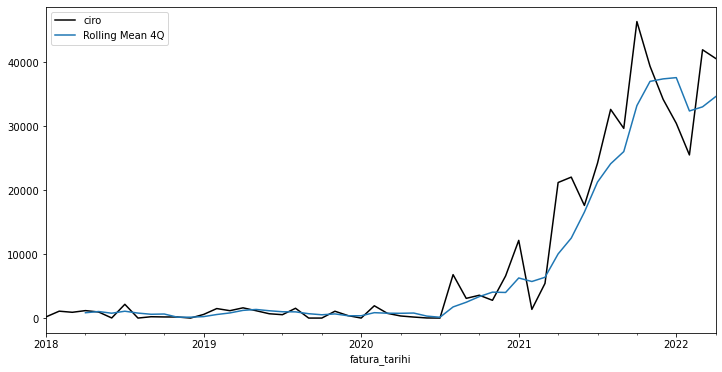

In [299]:
amazon_monthly[['ciro']].plot(figsize=(12,6), legend=True, label="amazon", cmap='gray')
amazon_monthly["ciro"].rolling(4, center=False).mean().plot(legend=True, label="Rolling Mean 4Q");
print("Mean is:", amazon["ciro"].mean())


**Is the variance constant?**

S.D is: 18.660490884242165


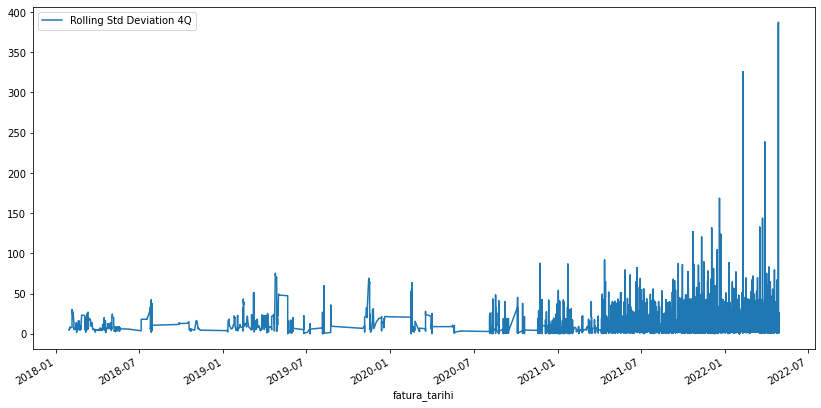

In [228]:
amazon["ciro"].rolling(4).std().plot(legend=True, label="Rolling Std Deviation 4Q");
print("S.D is:", amazon["ciro"].std())

S.D is: 13823.440057827907


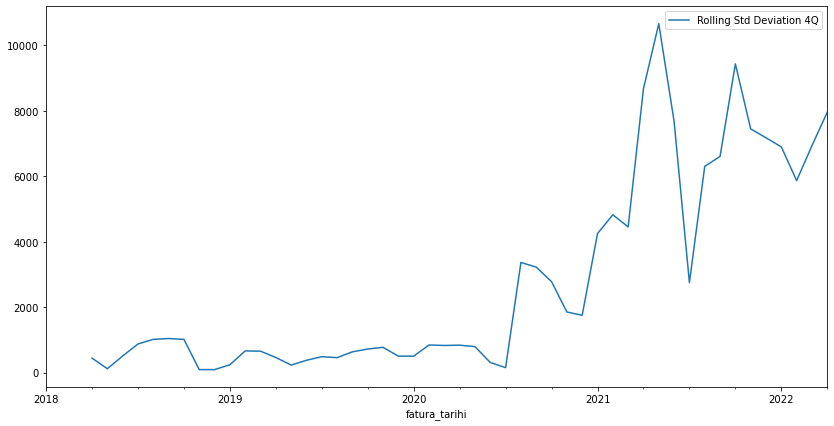

In [306]:
amazon_monthly["ciro"].rolling(4).std().plot(legend=True, label="Rolling Std Deviation 4Q");
print("S.D is:", amazon_monthly["ciro"].std())

**Coefficient of Variation:**

Coefficient of variation gives us an idea about the variability in the process, especially when looking at sales and demand. Note that this should be used for relative comparison and does not have a strict statistical defition. It's very common measure in demand planning and inventory analytics.

c.v = s.d/mean

If C.V<0.75 => Low Variability

If 0.75<C.V<1.3 => Medium Variability

If C.V>1.3 => High Variability

In [312]:
cv = amazon["ciro"].std()/amazon["ciro"].mean()
cv

0.9627010616800136

In [307]:
cv = amazon_monthly["ciro"].std()/amazon_monthly["ciro"].mean()
cv

1.5365282900271557

This is a high-variability process.

**Check for stationarity** <a id="88"></a>  [^](#Up)<br>

Augmented Dicky Fuller test is a statistical test for stionarity. If the p value is less than 0.05, the series is stationary, otherwise non-stationary. Use adfuller() from statsmodels

In [313]:
adf_test = amazon.ciro
adf_test = adf_test.dropna()
results = adfuller(adf_test)
print("The ADF p-valu is %4.4f" %(results[1]))

The ADF p-valu is 0.0000


In [314]:
#Calculate ad fuller statistic
adf = adfuller(amazon.ciro)[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.0 , Series is Stationary


In [308]:
adf_test = amazon_monthly.ciro
adf_test = adf_test.dropna()
results = adfuller(adf_test)
print("The ADF p-valu is %4.4f" %(results[1]))

The ADF p-valu is 0.9919


greater than 0.05 so it is not stationary.

In [311]:
adf_test = amazon_monthly.ciro.diff().diff()
adf_test = adf_test.dropna()
results = adfuller(adf_test)
print("The ADF p-valu is %4.4f" %(results[1]))

The ADF p-valu is 0.0332


now it is stationary. 

In [315]:
#Calculate ad fuller statistic
adf = adfuller(amazon_monthly.ciro)[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.9918958201145245 , Series is Non-Stationary


#  Time Series Models 

ARIMA models, also called Box-Jenkins models, are models that may possibly include autoregressive terms, moving average terms, and differencing operations. Various abbreviations are used:

* When a model only involves autoregressive terms it may be referred to as an AR model. 
* When a model only involves moving average terms, it may be referred to as an MA model.
* When no differencing is involved, the abbreviation ARMA may be used.
* When is involved, the abbreviation ARIMA may be used.
* When seasonality involved, the abbreviation SARIMA may be used.
* When other independent variables (exogenous inputs) are involved, the abbreviation ARMAX, ARIMAX, or SARIMAX may be used.

## Autoregressive Model (AR)


AR(p) Models: An AR signature corresponds to a PACF plot displaying a sharp cut-off and a more slowly decaying ACF <br>
* ACF Tails off
* PACF Cuts off after lag (p)
![image.png](attachment:image.png)

## Moving Average Model (MA)

MA(q) Models: An MA signature corresponds to an ACF plot displaying a sharp cut-off and a PACF plot that decays more slowly. <br>
* ACF Cuts off after lag (q)
* PACF Tails off
![image.png](attachment:image.png)

## ARMA Models


The time series is regressed on the previous values and the previous shock terms. <br>

ARMA(p, q): <br>
p is order of AR part <br>
q is order of MA part

ARMA(p,q) Models:
* ACF Tails off
* PACF Tails off
![image-2.png](attachment:image-2.png)

**Draw the autocorrelation  and partial autocorrelation graphs** <a id="84"></a>  [^](#T)<br>

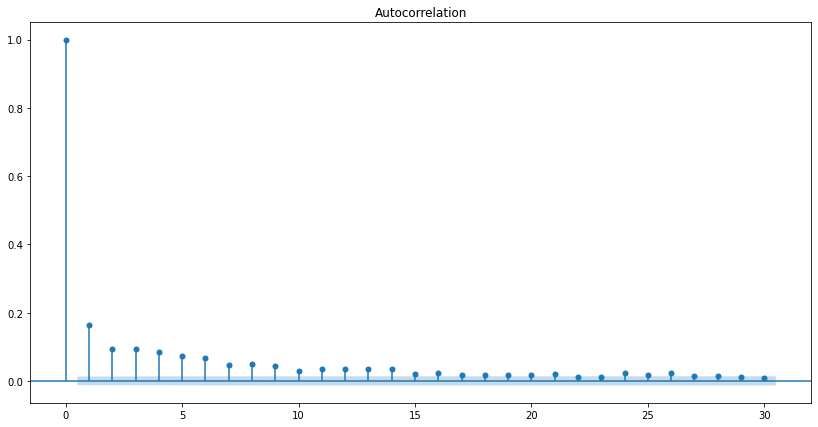

In [317]:
plot_acf(amazon.ciro.dropna(), alpha=0.05, lags=30)
plt.show()

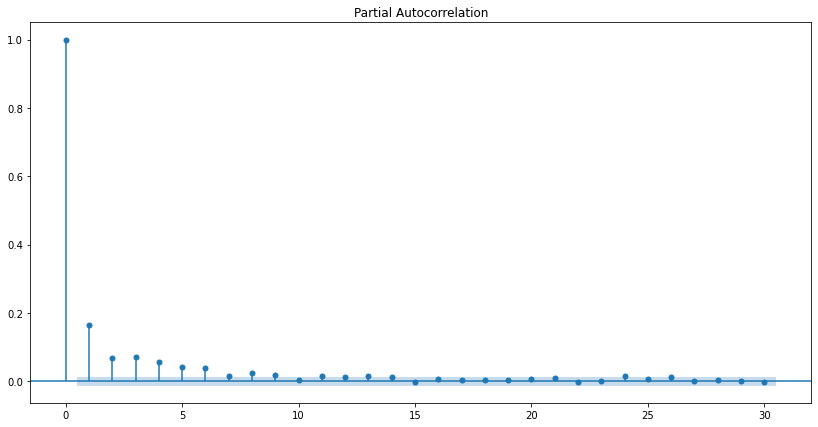

In [318]:
plot_pacf(amazon.ciro.dropna(), alpha=0.05, lags=30)
plt.show()

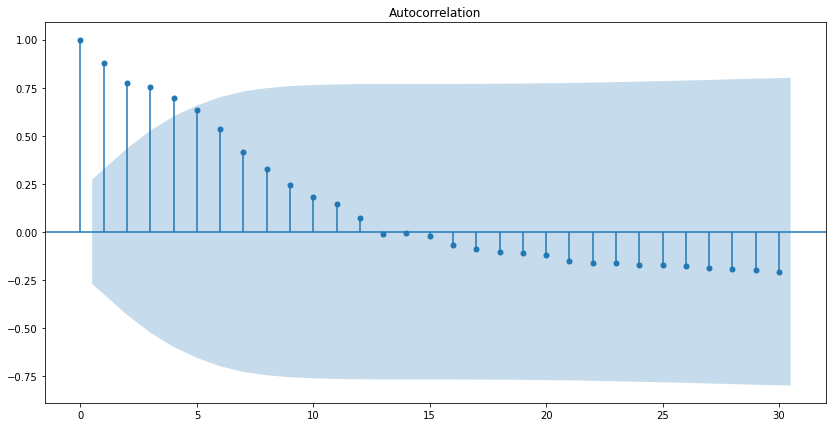

In [319]:
plot_acf(amazon_monthly.ciro.dropna(), alpha=0.05, lags=30)
plt.show()

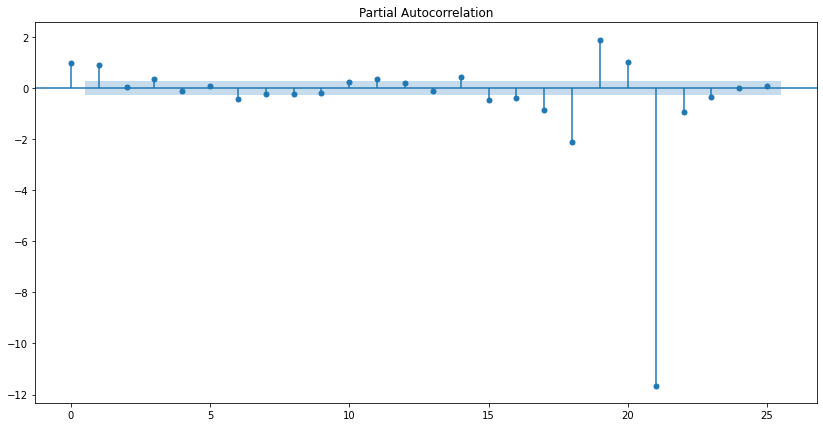

In [321]:
plot_pacf(amazon_monthly.ciro.dropna(), alpha=0.05, lags=25)
plt.show()

**Grid Search Over Parameters** <a id="85"></a>  [^](#T)<br>

In [234]:
search_data = amazon.ciro.dropna()
search_data_d = 1
order_aic_bic =[]
# Loop over AR order
for p in range(4):
    # Loop over MA order
    for q in range(4):
        # Fit model
        model = SARIMAX(search_data, order=(p,search_data_d,q))
        results = model.fit()
        # Add order and scores to list
        order_aic_bic.append((p, q, results.aic, results.bic))
        
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'AIC', 'BIC'])
print("Model order and AIC/BIC score (Sorted by AIC):\n", order_df.sort_values(by=['AIC', 'BIC']))
print("\nModel order and AIC/BIC score (Sorted by BIC):\n", order_df.sort_values(by=['BIC', 'AIC']))

Model order and AIC/BIC score (Sorted by AIC):
     p  q            AIC            BIC
6   1  2  208521.377658  208553.743166
11  2  3  208524.876665  208573.424927
13  3  1  208572.981065  208613.437950
9   2  1  208646.757270  208679.122778
14  3  2  208649.724828  208698.273090
3   0  3  208689.575727  208721.941235
10  2  2  208706.897235  208747.354119
5   1  1  208707.199515  208731.473646
15  3  3  208714.792468  208771.432106
7   1  3  208754.410876  208794.867761
2   0  2  208755.850870  208780.125001
1   0  1  209208.652666  209224.835419
12  3  0  212540.090970  212572.456478
8   2  0  213881.209643  213905.483774
4   1  0  216468.308520  216484.491274
0   0  0  222117.480468  222125.571845

Model order and AIC/BIC score (Sorted by BIC):
     p  q            AIC            BIC
6   1  2  208521.377658  208553.743166
11  2  3  208524.876665  208573.424927
13  3  1  208572.981065  208613.437950
9   2  1  208646.757270  208679.122778
14  3  2  208649.724828  208698.273090
3   0 

In [322]:
search_data = amazon_monthly.ciro.dropna()
search_data_d = 1
order_aic_bic =[]
# Loop over AR order
for p in range(4):
    # Loop over MA order
    for q in range(4):
        # Fit model
        model = SARIMAX(search_data, order=(p,search_data_d,q))
        results = model.fit()
        # Add order and scores to list
        order_aic_bic.append((p, q, results.aic, results.bic))
        
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'AIC', 'BIC'])
print("Model order and AIC/BIC score (Sorted by AIC):\n", order_df.sort_values(by=['AIC', 'BIC']))
print("\nModel order and AIC/BIC score (Sorted by BIC):\n", order_df.sort_values(by=['BIC', 'AIC']))

Model order and AIC/BIC score (Sorted by AIC):
     p  q          AIC          BIC
8   2  0  1016.486080  1022.281557
9   2  1  1016.546698  1024.274000
3   0  3  1016.654552  1024.381854
1   0  1  1016.700728  1020.564379
6   1  2  1016.964210  1024.691513
0   0  0  1017.265755  1019.197580
4   1  0  1017.471844  1021.335496
11  2  3  1017.576997  1029.167951
7   1  3  1017.965397  1027.624526
2   0  2  1018.195323  1023.990800
12  3  0  1018.373138  1026.100441
5   1  1  1018.390518  1024.185995
13  3  1  1018.401571  1028.060699
10  2  2  1018.692951  1028.352079
14  3  2  1019.940259  1031.531213
15  3  3  1020.699613  1034.222393

Model order and AIC/BIC score (Sorted by BIC):
     p  q          AIC          BIC
0   0  0  1017.265755  1019.197580
1   0  1  1016.700728  1020.564379
4   1  0  1017.471844  1021.335496
8   2  0  1016.486080  1022.281557
2   0  2  1018.195323  1023.990800
5   1  1  1018.390518  1024.185995
9   2  1  1016.546698  1024.274000
3   0  3  1016.654552  1024.

## 3.7) Model Diagnostics <a id="37"></a>                  [^](#ToC)<br>


If the model fits well the residuals will be white Gaussian noise

Create the 4 diagostics plots:<br>
results.plot_diagnostics()<br>
plt.show()

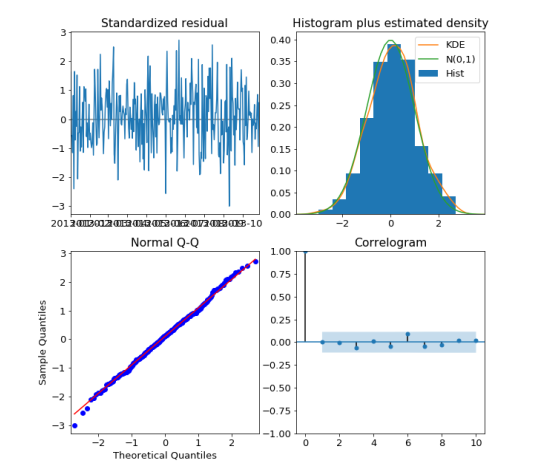

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

Model diagnostics suggests that the model residuals are normally distributed based on the following:

* In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

* The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

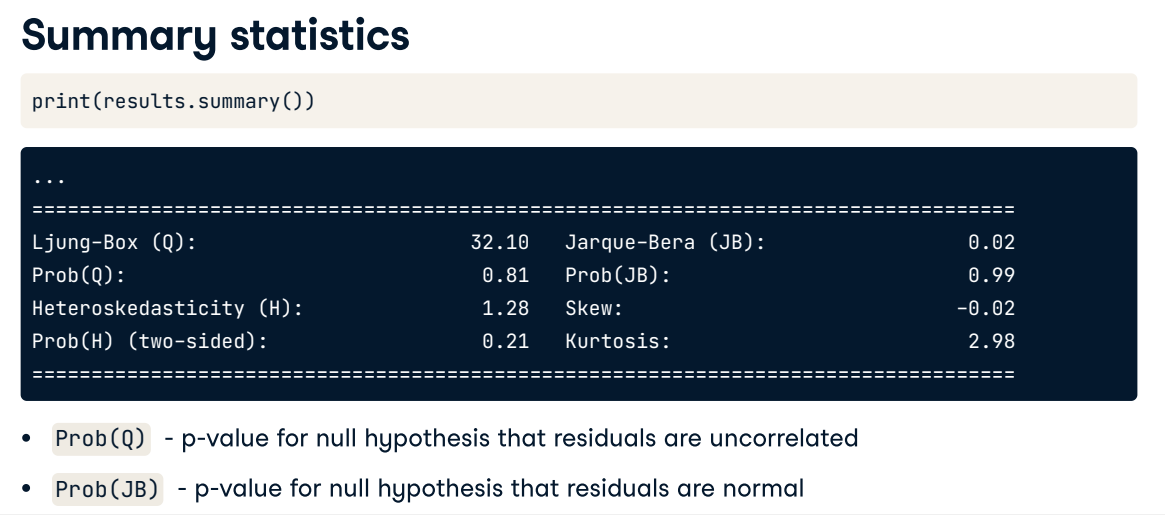

                               SARIMAX Results                                
Dep. Variable:                   ciro   No. Observations:                24135
Model:               SARIMAX(2, 0, 3)   Log Likelihood             -104377.133
Date:                Thu, 01 Sep 2022   AIC                         208766.266
Time:                        14:15:02   BIC                         208814.815
Sample:                             0   HQIC                        208782.007
                              - 24135                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0008      0.000      2.437      0.015       0.000       0.001
ar.L2          0.9992      0.000   3169.907      0.000       0.999       1.000
ma.L1          0.1333      0.003     50.588      0.0

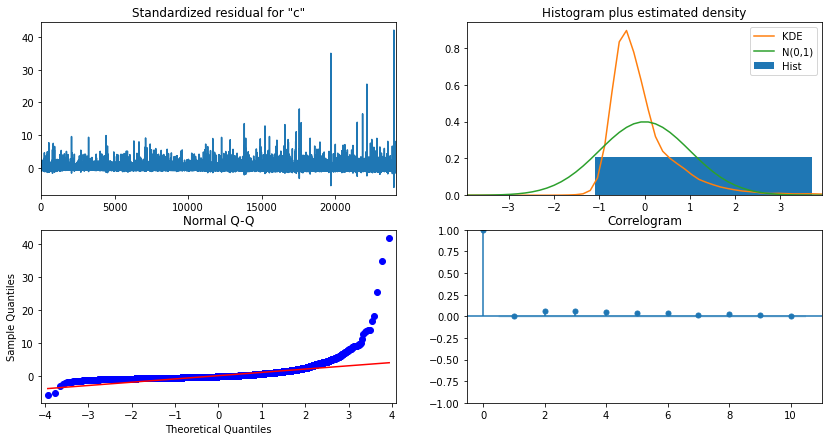

In [250]:
#we try first one p=3,q=2, diff=0
arima_data = amazon.ciro
arima = SARIMAX(arima_data, order=(2,0,3)) 

# Fit ARIMA model
arima_results = arima.fit()
print(arima_results.summary())

# Make ARIMA forecast of next 10 values
arima_value_forecast = arima_results.get_forecast(steps=10).predicted_mean

# Print forecast
print(arima_value_forecast)

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

# Create the 4 diagostics plots
arima_results.plot_diagnostics()
plt.show()

in q and j we reject null hypothesis.not normal distribution. variance not constant. not pass the test. we try another. 

ma is  significant. 
q is  significant. there is 0 autocorrelation in the correlogram. 
we didn't identify the problem well. so we get wrong estimate. since there's seasonality, we shouldn't use arima any more. 

prob(q)=> not zero => not significant=> zero autocorelation
jarqueber, normal distribution=> significant=> not close to normal

                               SARIMAX Results                                
Dep. Variable:                   ciro   No. Observations:                   52
Model:               SARIMAX(2, 2, 0)   Log Likelihood                -504.143
Date:                Thu, 01 Sep 2022   AIC                           1014.286
Time:                        23:46:11   BIC                           1020.022
Sample:                    01-31-2018   HQIC                          1016.471
                         - 04-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7876      0.114     -6.937      0.000      -1.010      -0.565
ar.L2         -0.5647      0.119     -4.735      0.000      -0.799      -0.331
sigma2      3.488e+07    6.6e-10   5.29e+16      0.0

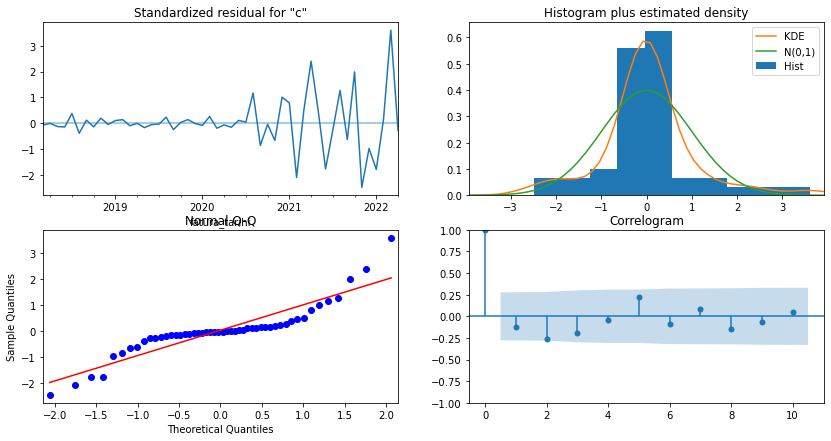

In [323]:
#we try first one p=3,q=2, diff=0
arima_data = amazon_monthly.ciro
arima = SARIMAX(arima_data, order=(2,2,0)) 

# Fit ARIMA model
arima_results = arima.fit()
print(arima_results.summary())

# Make ARIMA forecast of next 10 values
arima_value_forecast = arima_results.get_forecast(steps=10).predicted_mean

# Print forecast
print(arima_value_forecast)

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

# Create the 4 diagostics plots
arima_results.plot_diagnostics()
plt.show()

Now we add the seasonality and use auto_arima to find best parameters. we set period of seasonality to be 12. 

In [325]:
# Create auto_arima model
#grid search
pm_model = pm.auto_arima(amazon_monthly.ciro,
                    trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                        seasonal=True, m=12) # period of seasonality
                       
# Print model summary
#print(pm_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=795.563, Time=1.78 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=796.134, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=792.761, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=791.590, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=795.259, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=794.588, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=794.826, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=792.610, Time=0.06 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=796.586, Time=0.27 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=794.892, Time=0.09 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=793.375, Time=0.09 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=793.614, Time=0.06 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=792.885, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   

In [327]:
# Create auto_arima model
pm_model = pm.auto_arima(amazon_monthly.ciro,
                    trace=True,
                      error_action='ignore',
                      suppress_warnings=True,information_criterion='bic',
                        seasonal=True, m=12)
                       
# Print model summary
#print(pm_model.summary())

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[12]             : BIC=807.208, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=797.798, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=797.752, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=796.581, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=798.586, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=801.243, Time=0.10 sec
 ARIMA(0,1,1)(0,1,2)[12]             : BIC=801.481, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=797.600, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : BIC=804.904, Time=0.33 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[12]             : BIC=801.546, Time=0.09 sec
 ARIMA(0,1,2)(0,1,1)[12]             : BIC=800.030, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[12]             : BIC=798.605, Time=0.07 sec
 ARIMA(1,1,2)(0,1,1)[12]             : BIC=801.203, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   

                                      SARIMAX Results                                       
Dep. Variable:                                 ciro   No. Observations:                   52
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -388.996
Date:                              Fri, 02 Sep 2022   AIC                            789.992
Time:                                      00:49:40   BIC                            799.974
Sample:                                  01-31-2018   HQIC                           793.574
                                       - 04-30-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    709.3403    587.867      1.207      0.228    -442.857    1861.538
ar.L1         -0.49

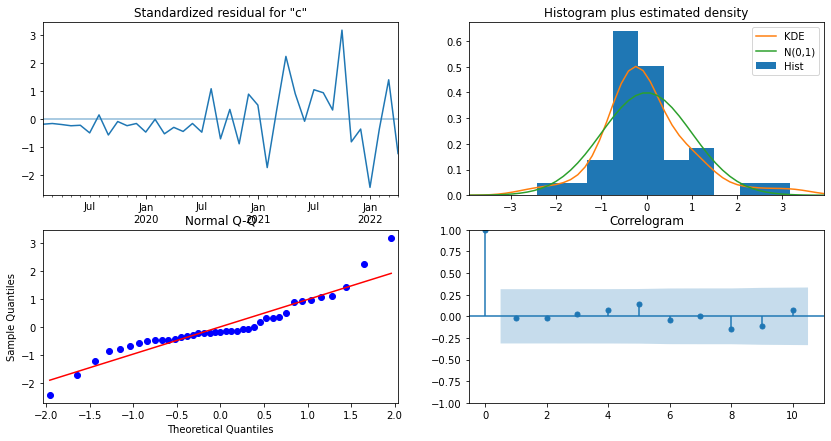

In [328]:
#first we use the result from aic. 
arima_data = amazon_monthly.ciro
arima = SARIMAX(arima_data, order=(1,1,2), seasonal_order=(0,1,1,12), trend = 'c')

# Fit ARIMA model
arima_results = arima.fit()
print(arima_results.summary())

# Make ARIMA forecast of next 12 values
arima_value_forecast = arima_results.get_forecast(steps=12).predicted_mean

# Print forecast
print(arima_value_forecast)

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

# Create the 4 diagostics plots
arima_results.plot_diagnostics()
plt.show()

the values are not significant, we try the other one. 

                                     SARIMAX Results                                      
Dep. Variable:                               ciro   No. Observations:                   52
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -392.795
Date:                            Fri, 02 Sep 2022   AIC                            791.590
Time:                                    00:58:07   BIC                            796.581
Sample:                                01-31-2018   HQIC                           793.381
                                     - 04-30-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3166      0.159     -1.986      0.047      -0.629      -0.004
ma.S.L12      -0.5353      0.293   

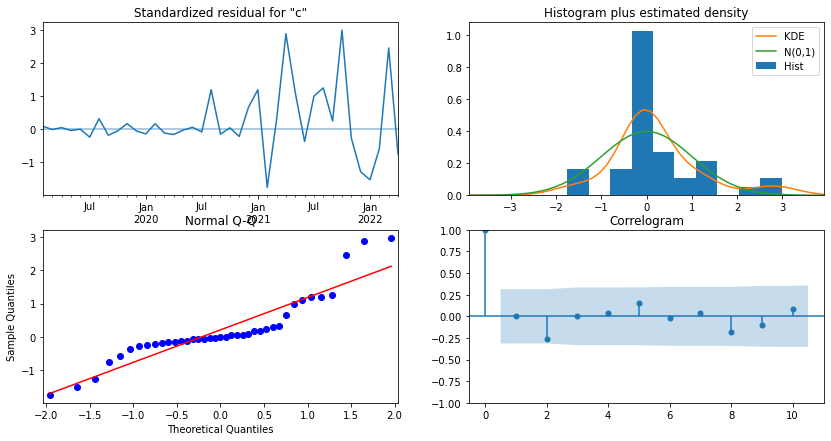

In [329]:
#now we use the result from bic. 
arima_data = amazon_monthly.ciro
arima = SARIMAX(arima_data, order=(0,1,1), seasonal_order=(0,1,1,12))

# Fit ARIMA model
arima_results = arima.fit()
print(arima_results.summary())

# Make ARIMA forecast of next 12 values
arima_value_forecast = arima_results.get_forecast(steps=12).predicted_mean

# Print forecast
print(arima_value_forecast)

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

# Create the 4 diagostics plots
arima_results.plot_diagnostics()
plt.show()

mean absolute error is less than the others. close to normal. uncorrelated. first ma is significant second ma not. 

                                      SARIMAX Results                                      
Dep. Variable:                                ciro   No. Observations:                   52
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -393.305
Date:                             Fri, 02 Sep 2022   AIC                            792.610
Time:                                     01:05:34   BIC                            797.600
Sample:                                 01-31-2018   HQIC                           794.400
                                      - 04-30-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3036      0.213     -1.423      0.155      -0.722       0.115
ar.S.L12      -0.6358      

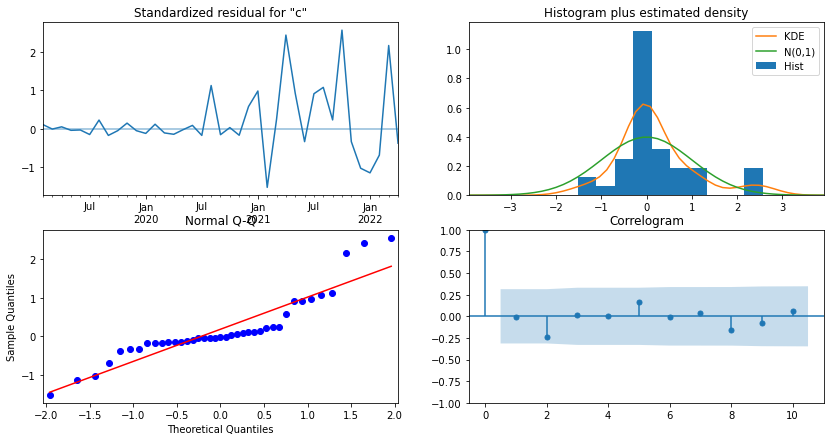

In [331]:
#now we try without second ma. the result from bic. 
arima_data = amazon_monthly.ciro
arima = SARIMAX(arima_data, order=(0,1,1), seasonal_order=(1,1,0,12))

# Fit ARIMA model
arima_results = arima.fit()
print(arima_results.summary())

# Make ARIMA forecast of next 12 values
arima_value_forecast = arima_results.get_forecast(steps=12).predicted_mean

# Print forecast
print(arima_value_forecast)

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

# Create the 4 diagostics plots
arima_results.plot_diagnostics()
plt.show()

not normal. we pick the previous one. 

                                      SARIMAX Results                                      
Dep. Variable:                                ciro   No. Observations:                   52
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -395.629
Date:                             Fri, 02 Sep 2022   AIC                            795.259
Time:                                     01:34:16   BIC                            798.586
Sample:                                 01-31-2018   HQIC                           796.453
                                      - 04-30-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4117      0.169     -2.435      0.015      -0.743      -0.080
sigma2      4.387e+07   7.1

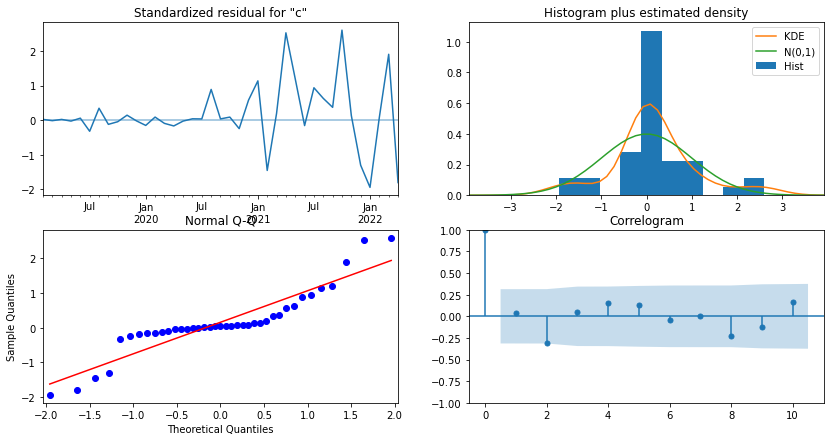

In [340]:
#now we use the result from bic. 
arima_data = amazon_monthly.ciro
arima = SARIMAX(arima_data, order=(0,1,1), seasonal_order=(0,1,0,12))

# Fit ARIMA model
arima_results = arima.fit()
print(arima_results.summary())

# Make ARIMA forecast of next 12 values
arima_value_forecast = arima_results.get_forecast(steps=12).predicted_mean

# Print forecast
print(arima_value_forecast)

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

# Create the 4 diagostics plots
arima_results.plot_diagnostics()
plt.show()

                                      SARIMAX Results                                       
Dep. Variable:                                 ciro   No. Observations:                   52
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -394.684
Date:                              Fri, 02 Sep 2022   AIC                            793.368
Time:                                      01:37:13   BIC                            796.695
Sample:                                  01-31-2018   HQIC                           794.562
                                       - 04-30-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.0000      0.150     -6.688      0.000      -1.293      -0.707
sigma2      2.629e+

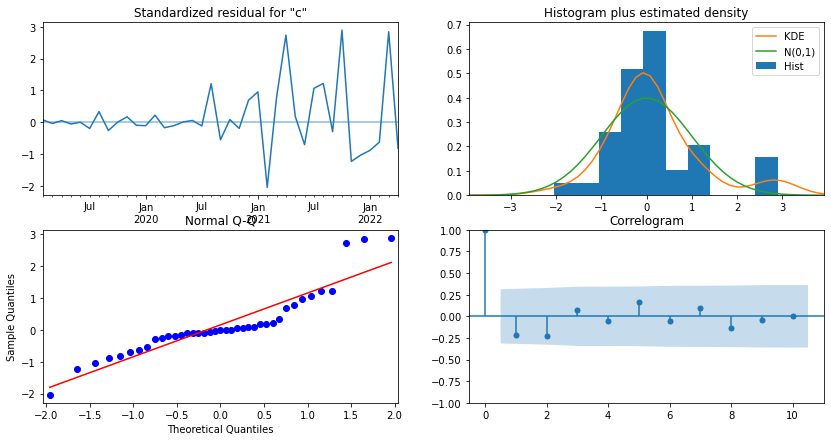

In [344]:
#now we use the result from bic. 
arima_data = amazon_monthly.ciro
arima = SARIMAX(arima_data, order=(0,1,0), seasonal_order=(0,1,1,12))

# Fit ARIMA model
arima_results = arima.fit()
print(arima_results.summary())

# Make ARIMA forecast of next 12 values
arima_value_forecast = arima_results.get_forecast(steps=12).predicted_mean

# Print forecast
print(arima_value_forecast)

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

# Create the 4 diagostics plots
arima_results.plot_diagnostics()
plt.show()

- prob(jb) < 0.05 => close to normal. left bottom corner, blue dots are close to the red line. and right top graph, green graph is close to kde .
- prob(q) > 0.05 => uncorrelated also the right bottom graph blue dots are all inside the blue pane.
- first graph close to white noise.
- we pick this one. 

**Which frequencies are prominent?**

We typically look at the time series in the time domain. But, we can also analyze the time series in the frequency domain. It's based on the assumption that it is made up of sine and cosine waves of different frequencies. This helps us detect periodic component of known/unknown frequencies. It can show additional details of the time series that can be easily missed. We do it with a Periodogram and Power Spectral Density plot.

Periodogram: We analyze frequency and associated intensity of frequency. Note that below I have invrted the frequency to obtain periods Period,T = 1/frequency. For example, a monthly time series has 12 seasonal periods, so we would obtain frequency = 1/12 = 0.0833. In our example, we expect to see the intensity to be high at period=4



In [332]:
from scipy import signal   

In [333]:
def plot_pgram(series,diff_order):
    """
    This function plots thd Power Spectral Density of a de-trended series. 
    PSD should also be calculated for a de-trended time series. Enter the order of differencing needed
    Output is a plot with PSD on Y and Time period on X axis
    
    Series: Pandas time series or np array
    differencing_order: int. Typically 1
    
    """
    #from scipy import signal    
    de_trended = series.diff(diff_order).dropna()
    f, fx = signal.periodogram(de_trended)
    freq=f.reshape(len(f),1) #reshape the array to a column
    psd = fx.reshape(len(f),1)
#     plt.figure(figsize=(5, 4)
    plt.plot(1/freq, psd  )
    plt.title("Periodogram")
    plt.xlabel("Time Period")
    plt.ylabel("Amplitude")
    plt.tight_layout()

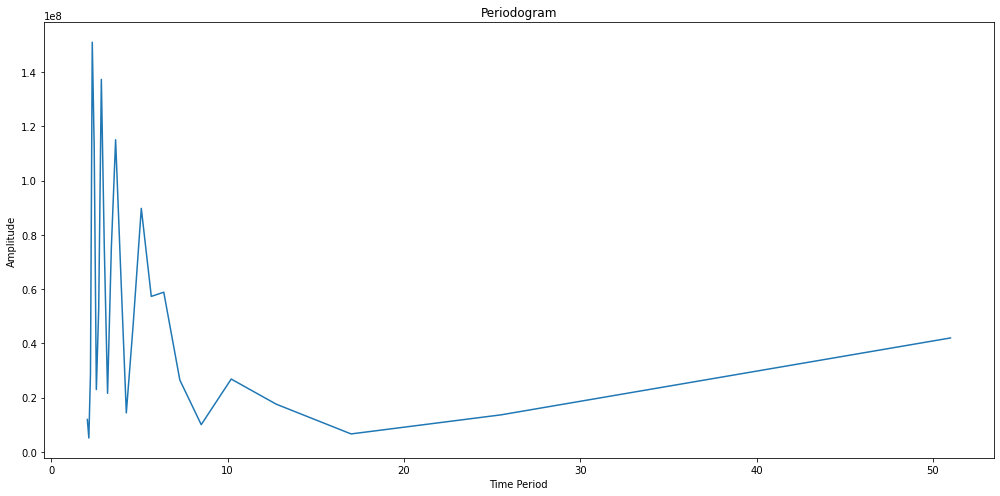

In [336]:
plot_pgram(amazon_monthly['ciro'],1);


**Power Spectral Density:** Periodogram assumes the frequencies to be harmonics of the fundamental frequency, whereas PSD allows the frequency to vary contunuously. PSD is calculated using autocovariance function (ACF seen above). Spectral density is the amount of variance per frequency interval. PSD shows the eaxct same information of the time series as the ACF, just in the frequency domain. We rarely use PSD for business time series analysis. Plot below shows that lower frequency content dominates the time series. If it has another bump at higher frequency, that would indicate cyclic behaviour. Sometime it can be easier to figure out MA vs AR process by looking at the PSD plot.

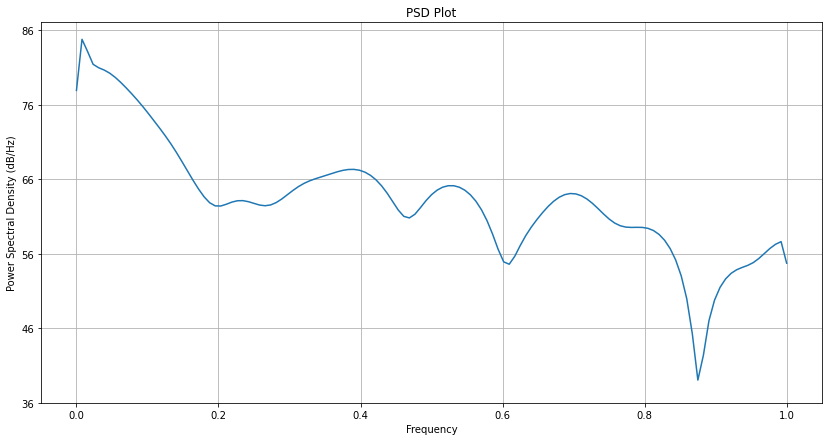

In [337]:
#Plot PSD
plt.psd(amazon_monthly["ciro"], detrend='linear');
plt.title("PSD Plot");


In [358]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(amazon_monthly.ciro, order=(0,1,0), seasonal_order=(0,1,1,12))
res = mod.fit(disp=False)
#print(res.summary())

################################
Mean Absolute Error (MAE): 699.75


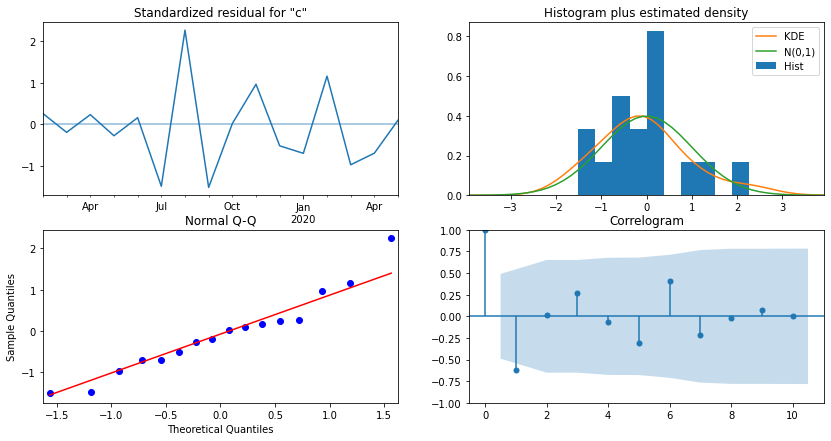

In [364]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(amazon_monthly.ciro.loc[:'2020-05-31'], order=(0,1,0), seasonal_order=(0,1,1,12))
fit_res = mod.fit(disp=False, maxiter=250)

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(fit_res.resid))
# Print mean absolute error
print("################################")
print("Mean Absolute Error (MAE): %4.2f" %(mae))

# Create the 4 diagostics plots
fit_res.plot_diagnostics()
plt.show()

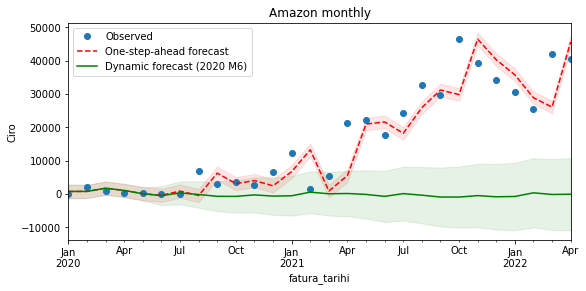

In [363]:
mod = sm.tsa.statespace.SARIMAX(amazon_monthly.ciro, order=(0,1,0), seasonal_order=(0,1,1,12))
res = mod.filter(fit_res.params)
data = amazon_monthly.ciro
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

# Dynamic predictions
predict_dy = res.get_prediction(dynamic='2020-05-31')
predict_dy_ci = predict_dy.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Amazon monthly', xlabel='Date', ylabel='Ciro')

# Plot data points
data.loc['2020-01-01':].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2020-01-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2020-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2020-01-01':].plot(ax=ax, style='g', label='Dynamic forecast (2020 M6)')
ci = predict_dy_ci.loc['2020-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='upper left')

################################
Mean Absolute Error (MAE): 1866.53


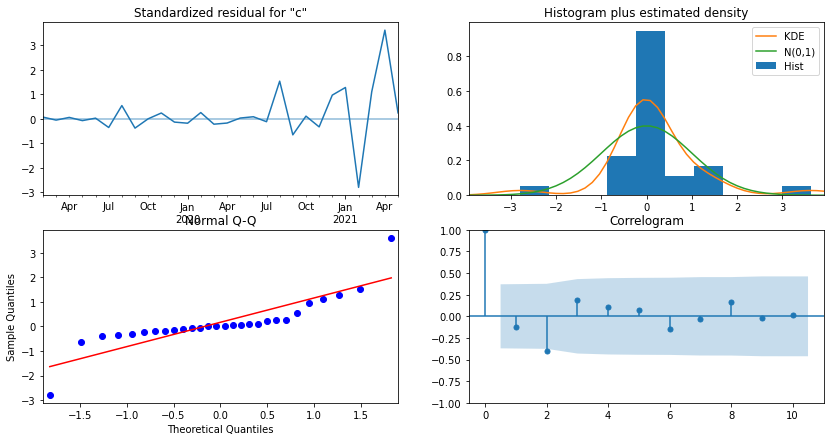

In [365]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(amazon_monthly.ciro.loc[:'2021-05-31'], order=(0,1,0), seasonal_order=(0,1,1,12))
fit_res = mod.fit(disp=False, maxiter=250)

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(fit_res.resid))
# Print mean absolute error
print("################################")
print("Mean Absolute Error (MAE): %4.2f" %(mae))

# Create the 4 diagostics plots
fit_res.plot_diagnostics()
plt.show()

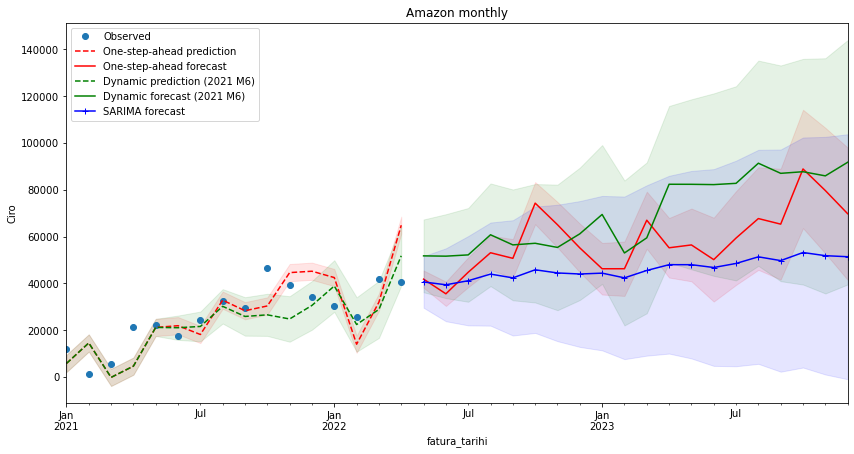

In [435]:
mod = sm.tsa.statespace.SARIMAX(amazon_monthly.ciro, order=(0,1,0), seasonal_order=(0,1,1,12))
res = mod.filter(fit_res.params)
data = amazon_monthly.ciro
# In-sample one-step-ahead predictions
predict = res.get_prediction()
forecast = res.get_forecast(steps=20)

predict_ci = predict.conf_int()
forecast_ci = forecast.conf_int()

# Dynamic predictions
predict_dy = res.get_prediction(dynamic='2021-05-31',steps = 20)
#print(predict_dy)
predict_dy_ci = predict_dy.conf_int()

forecast_dy = res.get_forecast(dynamic='2021-05-31',steps = 20)
#print(forecast_dy)
forecast_dy_ci = forecast_dy.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(14,7))
npre = 4
ax.set(title='Amazon monthly', xlabel='Date', ylabel='Ciro')

# Plot data points
data.loc['2021-01-01':].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2021-01-01':].plot(ax=ax, style='r--', label='One-step-ahead prediction')
forecast.predicted_mean.loc['2021-01-01':].plot(ax=ax, style='r', label='One-step-ahead forecast')

ci = predict_ci.loc['2021-01-01':]
ci_forecast = forecast_ci.loc['2022-01-01':]

ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
ax.fill_between(ci_forecast.index, ci_forecast.iloc[:,0], ci_forecast.iloc[:,1], color='r', alpha=0.1)

predict_dy.predicted_mean.loc['2021-01-01':].plot(ax=ax, style='g--', label='Dynamic prediction (2021 M6)')
forecast_dy.predicted_mean.loc['2021-01-01':].plot(ax=ax, style='g', label='Dynamic forecast (2021 M6)')

ci = predict_dy_ci.loc['2021-01-01':]
ci_forecast = forecast_dy_ci.loc['2022-01-01':]

ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)
ax.fill_between(ci_forecast.index, ci_forecast.iloc[:,0], ci_forecast.iloc[:,1], color='g', alpha=0.1)

arima_results.get_forecast(steps=20).predicted_mean.loc['2022-05-31':].plot(ax=ax,style =  'b+-', label='SARIMA forecast')
ci_arima = arima_results.get_forecast(steps=20).conf_int().loc['2022-01-01':]
ax.fill_between(ci_arima.index, ci_arima.iloc[:,0], ci_arima.iloc[:,1], color='b', alpha=0.1)

legend = ax.legend(loc='upper left')

In [410]:
forecast.predicted_mean.loc['2022-04-30':]

2022-05-31    41808.968832
Freq: M, dtype: float64

# Seasonal and Trend Decomposition using Loess (STL) 

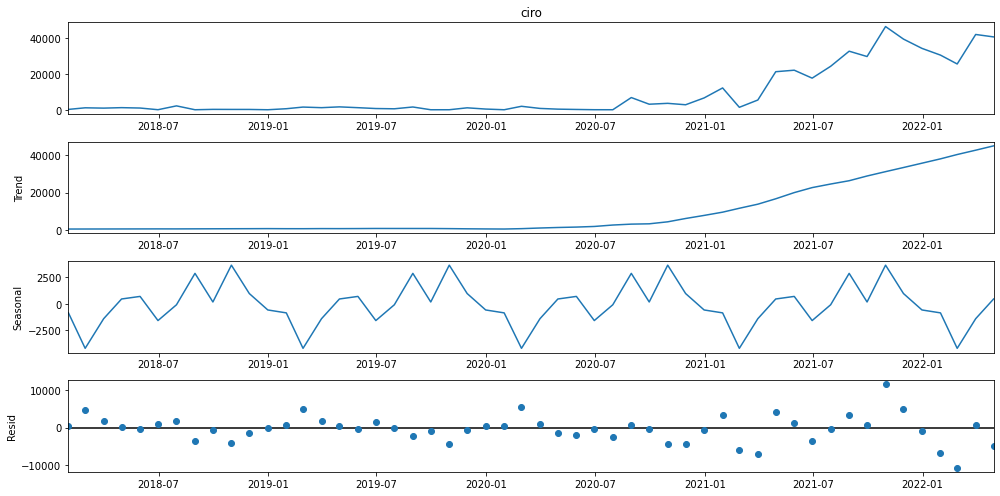

In [368]:
decomposition = sm.tsa.seasonal_decompose(amazon_monthly.ciro, model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

In [369]:
stl = STL(amazon_monthly.ciro)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid

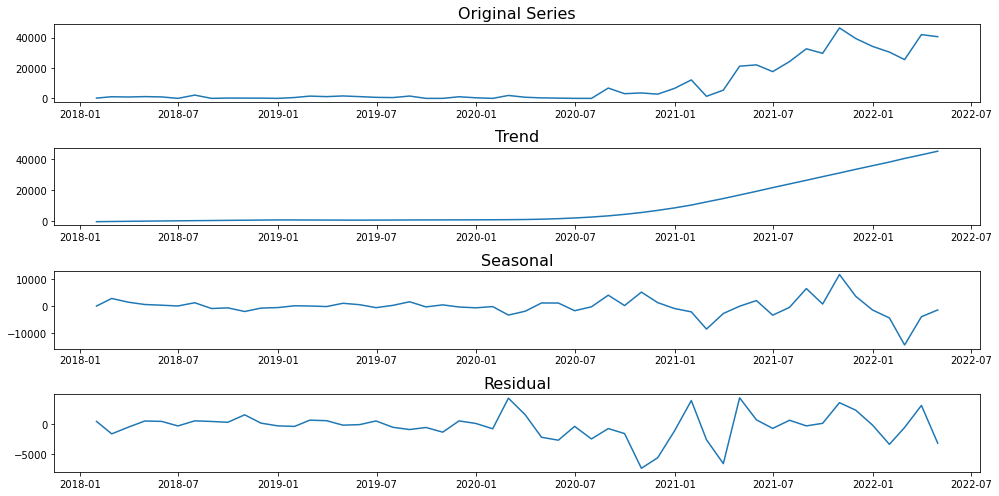

In [370]:
plt.figure(figsize=(14,7))

plt.subplot(4,1,1)
plt.plot(amazon_monthly.ciro)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

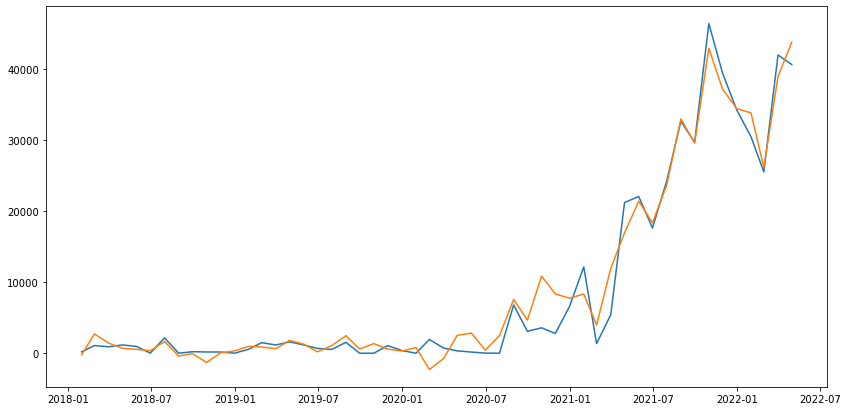

In [371]:
estimated = trend + seasonal
plt.figure(figsize = (14,7))
plt.plot(amazon_monthly.ciro)
plt.plot(estimated)

                           STL Decomposition and SARIMAX Results                            
Dep. Variable:                                    y   No. Observations:                   52
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -379.544
Date:                              Fri, 02 Sep 2022   AIC                            763.089
Time:                                      02:24:01   BIC                            766.416
Sample:                                  01-31-2018   HQIC                           764.283
                                       - 04-30-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9920      0.156     -6.356      0.000      -1.298      -0.686
sigma2      1.251e+

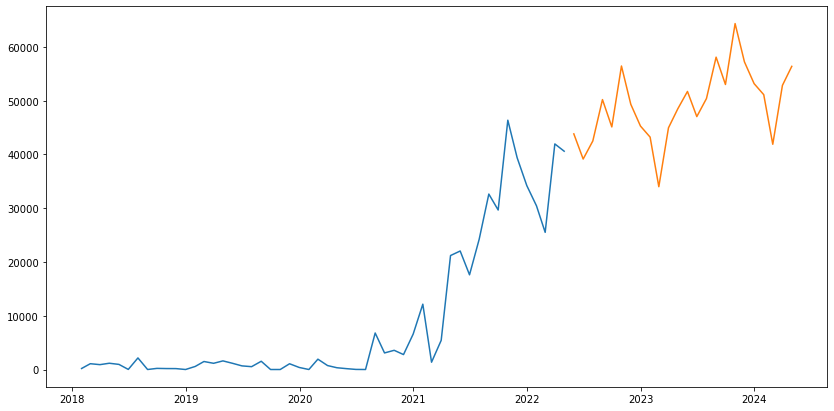

2022-05-31    43817.971872
2022-06-30    39141.740197
2022-07-31    42497.791896
2022-08-31    50195.659899
2022-09-30    45112.870169
2022-10-31    56441.183253
2022-11-30    49319.122702
2022-12-31    45276.757620
2023-01-31    43219.129344
2023-02-28    33995.038323
2023-03-31    44946.479203
2023-04-30    48486.385409
2023-05-31    51708.947281
2023-06-30    47032.715606
2023-07-31    50388.767304
2023-08-31    58086.635307
2023-09-30    53003.845577
2023-10-31    64332.158661
2023-11-30    57210.098111
2023-12-31    53167.733029
2024-01-31    51110.104753
2024-02-29    41886.013731
2024-03-31    52837.454611
2024-04-30    56377.360817
Freq: M, dtype: float64


In [373]:
stlforecast_data = amazon_monthly.ciro
stlf = STLForecast(stlforecast_data, SARIMAX, model_kwargs=dict(order=(0,1,0), seasonal_order=(0,1,1,12)))
stlf_res = stlf.fit()
print(stlf_res.summary())
forecast = stlf_res.forecast(24)
plt.figure(figsize=(14, 7))
plt.plot(stlforecast_data)
plt.plot(forecast)
plt.show()
#stlf_res.plot_diagnostics()
print(forecast)

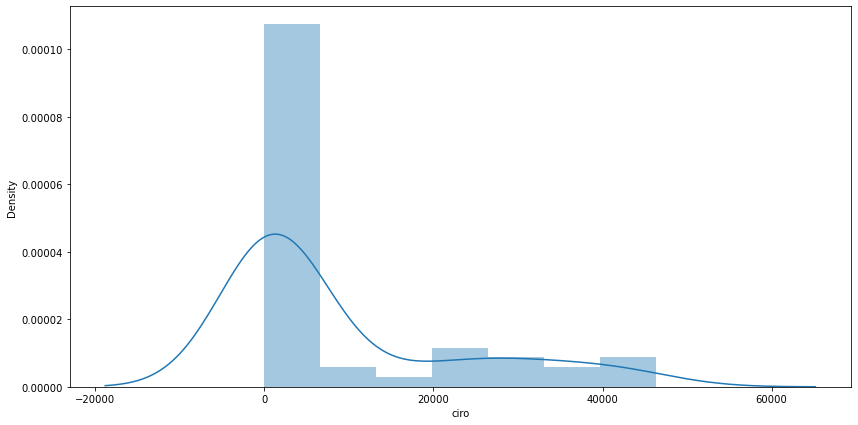

In [374]:
#Distribution Plot
sns.distplot(amazon_monthly['ciro']);


##  Anomaly Detection 

fatura_tarihi
2020-10-31    3569.487685
Freq: M, Name: ciro, dtype: float64


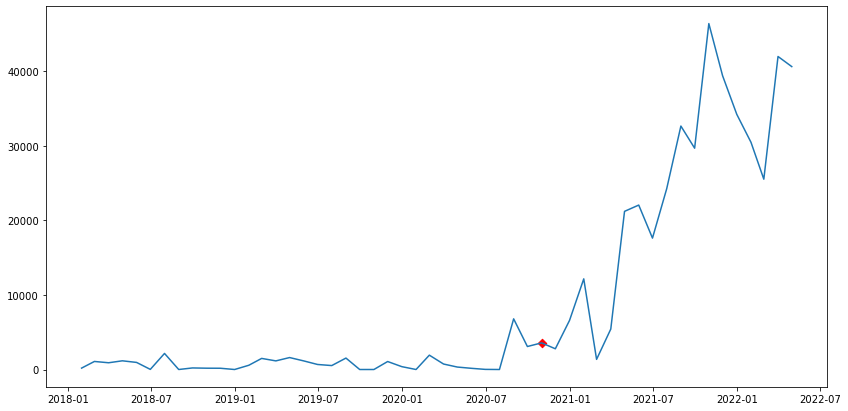

In [376]:
anomaly_detection = amazon_monthly.ciro
stl = STL(anomaly_detection)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev


anomalies = anomaly_detection[(resid < lower) | (resid > upper)]
print(anomalies)
plt.figure(figsize=(14,7))
plt.plot(anomaly_detection)  
for i in range(len(anomalies)):
    plt.scatter(anomalies.index[i], anomalies.iloc[i], color='r', marker='D')

##  Random Forest Regressor model 


In [497]:
# slightly modified code from the M4 competition
def split_into_train_test(data, in_num, fh):
    """
    Splits the series into train and test sets. Each step takes multiple points as inputs
    :param data: an individual TS
    :param fh: number of out of sample points
    :param in_num: number of input points for the forecast
    :return:
    """
    train, test = data[:-fh], data[-(fh + in_num):]
    x_train, y_train = train[:-1], np.roll(train, -in_num)[:-in_num]
    x_test, y_test = test[:-1], np.roll(test, -in_num)[:-in_num]
#     x_test, y_test = train[-in_num:], np.roll(test, -in_num)[:-in_num]

    # reshape input to be [samples, time steps, features] (N-NF samples, 1 time step, 1 feature)
    x_train = np.reshape(x_train, (-1, 1))
    x_test = np.reshape(x_test, (-1, 1))
    temp_test = np.roll(x_test, -1)
    temp_train = np.roll(x_train, -1)
    for x in range(1, in_num):
        x_train = np.concatenate((x_train[:-1], temp_train[:-1]), 1)
        x_test = np.concatenate((x_test[:-1], temp_test[:-1]), 1)
        temp_test = np.roll(temp_test, -1)[:-1]
        temp_train = np.roll(temp_train, -1)[:-1]

    return x_train, y_train, x_test, y_test

In [504]:
amazon_monthly.index.value_counts().sum()

52

In [506]:
52/4

13.0

In [510]:
amazon_monthly_train = amazon_monthly.iloc[:-13]
amazon_monthly_validation = amazon_monthly.iloc[-13:]

In [511]:
y=amazon_monthly.ciro.copy()
y = y.reset_index(drop=True)
fh = np.arange(1, len(amazon_monthly_validation.ciro) + 1)  # we add 1 because the `stop` value is exclusive in `np.arange`
fh #forcast horizon

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [512]:
# now we can split the actual values of the time series
x_train, y_train, x_test, y_test = split_into_train_test(y.values, 7, len(fh))
print(x_train.shape, y_train.shape)

(32, 7) (32,)


In [513]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

In [518]:
SimpleExpS = SimpleExpSmoothing(amazon_monthly.ciro).fit()
fcast3 = SimpleExpS.forecast(13).rename(r'$\alpha=%s$'%SimpleExpS.model.params['smoothing_level'])
print(fcast3.index)
mae = np.mean(np.abs(fcast3 - amazon_monthly.ciro))
# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

DatetimeIndex(['2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31'],
              dtype='datetime64[ns]', freq='M')
Mean Absolute Error (MAE):  nan


In [519]:
# modified code from the M4 competition
predictions = []
last_window = x_train[-1, :].reshape(1, -1)  # make it into 2d array

last_prediction = model.predict(last_window)[0]  # take value from array

for i in range(len(fh)):
    # append prediction
    predictions.append(last_prediction)
    
    # update last window using previously predicted value
    last_window[0] = np.roll(last_window[0], -1)
    last_window[0, (len(last_window[0]) - 1)] = last_prediction
    
    # predict next step ahead
    last_prediction = model.predict(last_window)[0]

y_pred_rec = pd.Series(predictions, index=fcast3.index)
mae = np.mean(np.abs(y_pred_rec - amazon_monthly_validation["ciro"]))
# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

Mean Absolute Error (MAE):  nan


##  Holt-Winters’ Seasonal Model
**Suitable for time series data with trend and/or seasonal components**


![image.png](attachment:image.png)

In [438]:
amazon_monthly.head()

,adet,birim_fiyat,enflasyon,ciro,nakliye,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,
2018-01-31,11.0,173.130841,14.0,187.943925,36.172137,0.0,10.0,0.0,10.0
2018-02-28,58.0,980.744915,56.1,1078.050577,184.477896,0.0,51.0,0.0,51.0
2018-03-31,53.0,833.990026,61.5,903.775073,148.305760,0.0,41.0,0.0,41.0
2018-04-30,63.0,1104.699442,75.4,1164.914396,209.798392,0.0,58.0,0.0,58.0
2018-05-31,71.0,771.339040,111.3,949.510485,191.712324,0.0,53.0,0.0,53.0


In [440]:
amazon_monthly.loc['2018-01-31':].ciro

fatura_tarihi
2018-01-31      187.943925
2018-02-28     1078.050577
2018-03-31      903.775073
2018-04-30     1164.914396
2018-05-31      949.510485
2018-06-30       15.980000
2018-07-31     2152.524319
2018-08-31        0.000000
2018-09-30      208.805859
2018-10-31      174.981308
2018-11-30      167.747664
2018-12-31        0.000000
2019-01-31      568.514019
2019-02-28     1486.436347
2019-03-31     1154.252336
2019-04-30     1600.949187
2019-05-31     1149.217466
2019-06-30      673.970078
2019-07-31      527.578104
2019-08-31     1531.829498
2019-09-30        0.000000
2019-10-31        0.000000
2019-11-30     1068.918506
2019-12-31      381.036729
2020-01-31        0.000000
2020-02-29     1922.299982
2020-03-31      734.289065
2020-04-30      329.219351
2020-05-31      158.574334
2020-06-30       16.149533
2020-07-31        0.000000
2020-08-31     6789.142370
2020-09-30     3080.709113
2020-10-31     3569.487685
2020-11-30     2776.717980
2020-12-31     6586.197270
2021-01-31    

In [441]:
amazon_monthly_holt = amazon_monthly[amazon_monthly.ciro > 0]

In [450]:
amazon_monthly_holt

,adet,birim_fiyat,enflasyon,ciro,nakliye,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,
2018-01-31,11.0,173.130841,14.0,187.943925,36.172137,0.0,10.0,0.0,10.0
2018-02-28,58.0,980.744915,56.1,1078.050577,184.477896,0.0,51.0,0.0,51.0
2018-03-31,53.0,833.990026,61.5,903.775073,148.305760,0.0,41.0,0.0,41.0
2018-04-30,63.0,1104.699442,75.4,1164.914396,209.798392,0.0,58.0,0.0,58.0
2018-05-31,71.0,771.339040,111.3,949.510485,191.712324,0.0,53.0,0.0,53.0
2018-06-30,2.0,7.990000,1.9,15.980000,3.617214,0.0,1.0,0.0,1.0
2018-07-31,128.0,1717.786807,169.1,2152.524319,321.932015,0.0,89.0,0.0,89.0
2018-09-30,10.0,163.974083,13.3,208.805859,25.320496,0.0,7.0,0.0,7.0
2018-10-31,13.0,174.981308,29.9,174.981308,47.023778,0.0,13.0,0.0,13.0


In [451]:
#arima_results.get_forecast(steps=20).predicted_mean.loc['2022-05-31':].plot(ax=ax,style =  'b+-', label='SARIMA forecast')

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(14,7))
npre = 4
ax.set(title='Amazon monthly', xlabel='Date', ylabel='Ciro')

# Plot data points
data.loc['2021-01-01':].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2021-01-01':].plot(ax=ax, style='r--', label='One-step-ahead prediction')
forecast.predicted_mean.loc['2021-01-01':].plot(ax=ax, style='r', label='One-step-ahead forecast')

ci = predict_ci.loc['2021-01-01':]
ci_forecast = forecast_ci.loc['2022-01-01':]

ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
ax.fill_between(ci_forecast.index, ci_forecast.iloc[:,0], ci_forecast.iloc[:,1], color='r', alpha=0.1)

predict_dy.predicted_mean.loc['2021-01-01':].plot(ax=ax, style='g--', label='Dynamic prediction (2021 M6)')
forecast_dy.predicted_mean.loc['2021-01-01':].plot(ax=ax, style='g', label='Dynamic forecast (2021 M6)')

ci = predict_dy_ci.loc['2021-01-01':]
ci_forecast = forecast_dy_ci.loc['2022-01-01':]

ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)
ax.fill_between(ci_forecast.index, ci_forecast.iloc[:,0], ci_forecast.iloc[:,1], color='g', alpha=0.1)

arima_results.get_forecast(steps=20).predicted_mean.loc['2022-05-31':].plot(ax=ax,style =  'b+-', label='SARIMA forecast')
ci_arima = arima_results.get_forecast(steps=20).conf_int().loc['2022-01-01':]
ax.fill_between(ci_arima.index, ci_arima.iloc[:,0], ci_arima.iloc[:,1], color='b', alpha=0.1)

legend = ax.legend(loc='upper left')

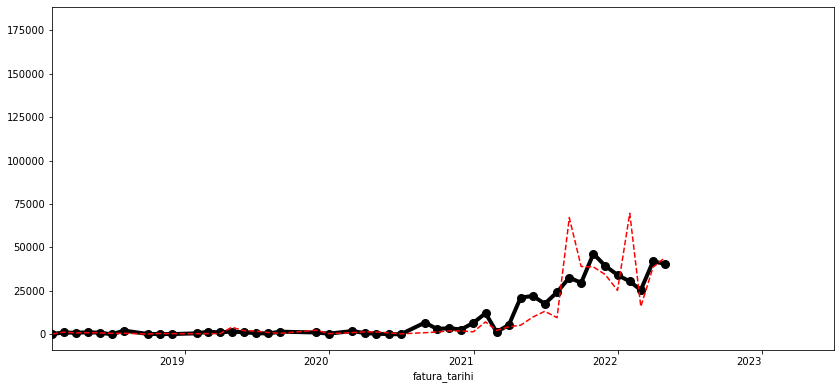

46     48646.772151
47     48900.328089
48     33067.836336
49    152836.349872
50    116035.119751
51    125972.169513
52    106275.416701
53     76393.209802
54    179272.912775
55     59819.903709
56    116706.940501
57    128745.291233
dtype: float64


In [525]:
fit1_amazon = ExponentialSmoothing(amazon_monthly_holt.ciro, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox='lag')
#fit2 = ExponentialSmoothing(amazon_monthly_holt.ciro, seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)
#fit3 = ExponentialSmoothing(amazon_monthly_holt.ciro, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
#fit4 = ExponentialSmoothing(amazon_months.ciro, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
#print(fit1_amazon)
start, end = '2018-01-31', '2023-07-01'

fig, ax = plt.subplots(figsize=(14,7))
#plt.figure(figsize=(14, 7))

ax.plot(amazon_monthly_holt.ciro.loc[start:end],
marker='o', markersize=8, linestyle='-',label='ORIGINAL_DATA',linewidth=4,color='k')



fit1.fittedvalues['2018-01-31':'2023-07-01'].plot(ax=ax, style='--', color='red')
#print(fit1.fittedvalues.loc['2018-01-31':])
#fit2.fittedvalues.plot(style='--', color='green')

fit1.forecast(12).loc['2022-05-31':].plot(ax=ax,style='--', marker='o', color='blue')
#fit2.forecast(12).plot(style='--', marker='o', color='green')
#fit3.forecast(12).plot(style='--', marker='o', color='blue')
#fit4.forecast(12).plot(style='--', marker='o', color='purple')
plt.xlim('2018-01-31', '2023-07-01');
plt.show()
print(fit1.forecast(12).loc['2022-05-31':])
#print(fit2.forecast(12))
#print(fit3.forecast(12))
#print(fit4.forecast(12))

## Smooth trend model without seasonal or cyclical components


In [496]:
# smooth trend model without seasonal or cyclical components
#https://www.youtube.com/watch?v=v5ijNXvlC5A
model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None, 
}
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html
smooth_mod = sm.tsa.UnobservedComponents(amazon_monthly.ciro, **model)
smooth_res = smooth_mod.fit()

smooth_predict_res = smooth_res.get_forecast(steps=7)

mae = np.mean(np.abs(smooth_predict_res.predicted_mean - amazon['ciro'].iloc[:-7]))

# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

Mean Absolute Error (MAE):  nan


## Ensemble model 


In [ ]:
ensemble_amazon = (daily_sales_Sales_A_SARIMAX_results.get_forecast(steps=12).predicted_mean + 
           smooth_predict_res.predicted_mean + 
           llk_predict_res.predicted_mean)/3
mae = np.mean(np.abs(esseble - daily_sales_validation["Sales_A"]))
# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                   18
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 -47.157
Date:                Thu, 01 Sep 2022   AIC                            106.315
Time:                        14:16:30   BIC                            111.657
Sample:                    03-31-2018   HQIC                           107.051
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6195      0.834      0.743      0.458      -1.016       2.254
ar.L2          0.3700      0.808      0.458      0.647      -1.214       1.954
ma.L1          0.3267    245.357      0.001      0.9

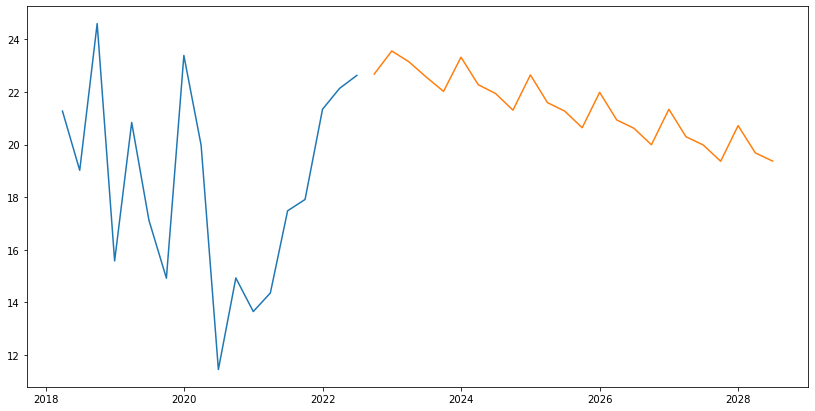

2022-09-30    22.680809
2022-12-31    23.555875
2023-03-31    23.148332
2023-06-30    22.569792
2023-09-30    22.020721
2023-12-31    23.320431
2024-03-31    22.274299
2024-06-30    21.941260
2024-09-30    21.308008
2024-12-31    22.646399
2025-03-31    21.593085
2025-06-30    21.269907
2025-09-30    20.640107
2025-12-31    21.984284
2026-03-31    20.935831
2026-06-30    20.617805
2026-09-30    19.992995
2026-12-31    21.342170
2027-03-31    20.298658
2027-06-30    19.985543
2027-09-30    19.365602
2027-12-31    20.719610
2028-03-31    19.680894
2028-06-30    19.372537
Freq: Q-DEC, dtype: float64


In [251]:
stlforecast_data = amazon_q.ciro
stlf = STLForecast(stlforecast_data, SARIMAX, model_kwargs=dict(order=(2,0,3)))
stlf_res = stlf.fit()
print(stlf_res.summary())
forecast = stlf_res.forecast(24)
plt.figure(figsize=(14, 7))
plt.plot(stlforecast_data)
plt.plot(forecast)
plt.show()
#stlf_res.plot_diagnostics()
print(forecast)

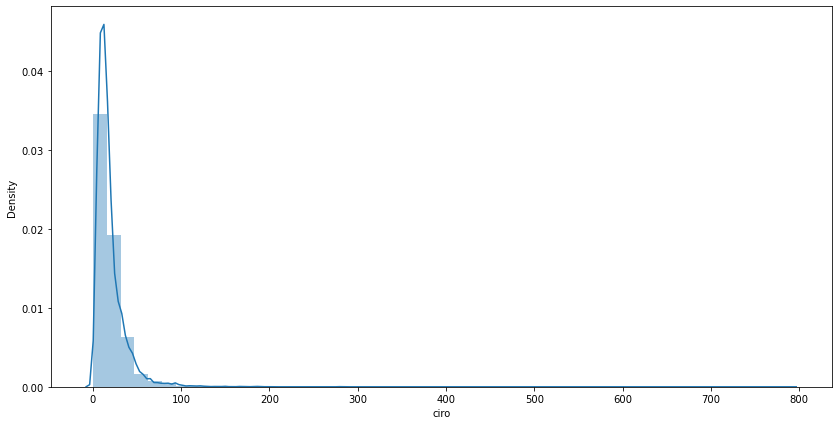

In [240]:
#Distribution Plot
sns.distplot(amazon['ciro']);


In [242]:
import statsmodels.api as sm

In [244]:
#Jarque Bera Stastical Test for Normality
from scipy.stats import jarque_bera as jb
is_norm=jb(amazon['ciro'])[1]
print(f"p value:{is_norm.round(2)}", ", Series is Normal" if is_norm >0.05 else ", Series is Non-Normal")


p value:0.0 , Series is Non-Normal


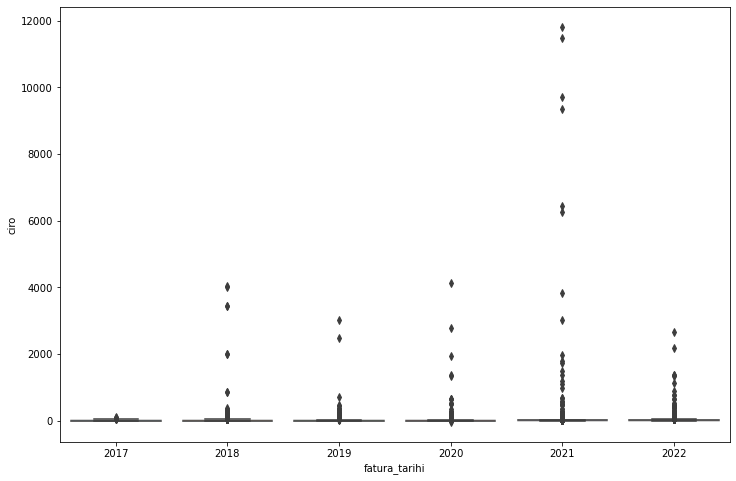

In [16]:
#box plot to see distribution of sales in each year
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data=combined_daily, x=combined_daily.index.year, y = 'ciro',  ax = ax, boxprops=dict(alpha=.3));
#sns.swarmplot(data=combined_daily, x=combined_daily.index.year, y = 'ciro');

In [124]:
combined_daily.index = pd.to_datetime(combined_daily.index)

In [125]:
combined_daily = combined_daily.sort_index()

In [126]:
combined_daily[:'2022'].ciro

fatura_tarihi
2017-08-29    10.000000
2017-08-29    20.000000
2017-08-29     8.200000
2017-08-29    13.000000
2017-09-01    11.682243
                ...    
2022-04-29     4.210000
2022-04-29     4.200000
2022-04-29     3.790000
2022-04-29     6.300000
2022-04-29     5.010000
Name: ciro, Length: 39297, dtype: float64

In [20]:
#%Growth each year. Excluding 2022 since we have only 2 quarters
growth = combined_daily[:'2022'].groupby(combined_daily[:'2022'].index.year)["ciro"].sum().pct_change()
growth*100


fatura_tarihi
2017            NaN
2018    2400.912342
2019     -13.128563
2020     114.000477
2021     417.855592
2022     -55.518779
Name: ciro, dtype: float64

In [21]:
#def add_freq(idx, freq=None):
#    """Add a frequency attribute to idx, through inference or directly.
#
 #   Returns a copy.  If `freq` is None, it is inferred.
  #  """
#
 #   idx = idx.copy()
  #  if freq is None:
   #     if idx.freq is None:
    #        freq = pd.infer_freq(idx)
     #   else:
      #      return idx
   # idx.freq = pd.tseries.frequencies.to_offset(freq)
    #if idx.freq is None:
     #   raise AttributeError('no discernible frequency found to `idx`.  Specify'
      #                       ' a frequency string with `freq`.')
   # return idx



In [22]:
#combined_daily.asfreq('Q')

In [23]:
#add_freq(idx)

In [24]:
#add_freq(idx, freq='M')

In [25]:
#print(combined_daily.index.freq)

In [26]:
#combined_daily.index.freq ='M'

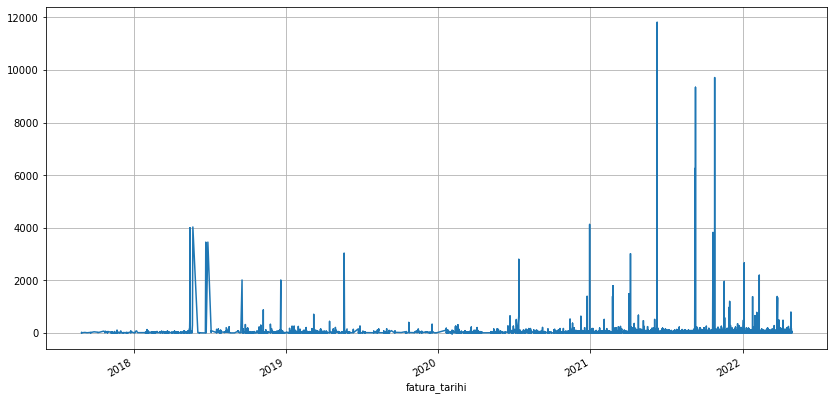

In [27]:
plt.figure(figsize=(14, 7))
combined_daily.ciro.plot(grid=True)
plt.show()

In [40]:
combined_daily[combined_daily.ciro > 6000]

,Customer,posta_kodu,city,country,COUNTRY NAME,satis_yapilan_platform,satilan_urun,adet,birim_fiyat,enflasyon,ciro,day_of_week,nakliye,category,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,,,,,,,,,,
2021-06-10,ID18074,1000,other,ATA,ANTARCTICA,b2b,ezine käse 1000gr,1700.0,6.75,2.3,11475.00,Thursday,3.617214,peynir,1.0,0.0,0.0,1.0
2021-06-10,ID18074,1000,other,ATA,ANTARCTICA,b2b,izmir tulum 1000gr,1700.0,6.95,2.3,11815.00,Thursday,3.617214,peynir,1.0,0.0,0.0,1.0
2021-06-10,ID18074,1000,other,ATA,ANTARCTICA,b2b,izmir tulum teneke,1001.0,6.45,2.3,6456.45,Thursday,3.617214,peynir,1.0,0.0,0.0,1.0
2021-09-09,ID18074,53797,Lohmar,DEU,GERMANY,b2b,izmir tulum-weiss käse teneke,1002.0,6.25,3.9,6262.50,Thursday,3.617214,peynir,1.0,0.0,0.0,1.0
2021-09-10,ID25062,1000,other,ATA,ANTARCTICA,b2b,wabenhonig klein holzrahmen,1050.0,8.90,3.9,9345.00,Friday,3.617214,wabenhonig,1.0,0.0,0.0,1.0
2021-10-26,ID18074,11011,Berlin,DEU,GERMANY,b2b,ezine käse 1000gr,1506.0,6.45,4.5,9713.70,Tuesday,3.617214,peynir,1.0,0.0,0.0,1.0


In [63]:
combined_daily[combined_daily.ciro > 2000]

,Customer,posta_kodu,city,country,COUNTRY NAME,satis_yapilan_platform,satilan_urun,adet,birim_fiyat,enflasyon,ciro,day_of_week,nakliye,category,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,,,,,,,,,,
2018-05-16,ID10405,3067 EZ,ROTTERDAM,NLD,NETHERLANDS,b2b,pistazien,500.00,8.00,2.1,4000.00,Wednesday,3.617214,antep fistigi,0.0,1.0,0.0,1.0
2018-05-23,ID10423,3067 EZ,ROTTERDAM,NLD,NETHERLANDS,b2b,pistazien,504.00,8.00,2.1,4032.00,Wednesday,3.617214,antep fistigi,0.0,1.0,0.0,1.0
2018-06-23,ID10405,3067 EZ,ROTTERDAM,NLD,NETHERLANDS,b2b,pistazien,432.00,8.00,1.9,3456.00,Saturday,3.617214,antep fistigi,0.0,1.0,0.0,1.0
2018-06-28,ID10405,3067 EZ,ROTTERDAM,NLD,NETHERLANDS,b2b,pistazien,432.00,8.00,1.9,3456.00,Thursday,3.617214,antep fistigi,0.0,1.0,0.0,1.0
2018-09-18,ID10590,59586,Neu Berlin,DEU,GERMANY,b2b,pistazien,252.00,8.00,1.9,2016.00,Tuesday,3.617214,antep fistigi,0.0,1.0,0.0,1.0
2018-12-20,IDID -2,22529,Hamburg,DEU,GERMANY,b2b,pistazien,252.00,8.00,2.1,2016.00,Thursday,3.617214,antep fistigi,0.0,1.0,0.0,1.0
2019-05-21,ID10956,19 400,KOROPI-HELLAS,GRC,GREECE,b2b,kangal knoblauchwurst 1kg,400.00,6.25,1.4,2500.00,Tuesday,3.617214,sucuk,0.0,1.0,0.0,1.0
2019-05-21,ID10956,19 400,KOROPI-HELLAS,GRC,GREECE,b2b,pastirma 1kg( 100 gr),160.00,19.00,1.4,3040.00,Tuesday,3.617214,pastirma,0.0,1.0,0.0,1.0
2020-07-13,ID11503,1063 TK,Amsterdam,NLD,NETHERLANDS,b2b,10 kg. disar schwarzolive aus gemlik,70.00,40.00,-0.1,2800.00,Monday,3.617214,zeytin,1.0,0.0,0.0,1.0


In [72]:
combined_daily[combined_daily.ciro >= 4000]

,Customer,posta_kodu,city,country,COUNTRY NAME,satis_yapilan_platform,satilan_urun,adet,birim_fiyat,enflasyon,ciro,day_of_week,nakliye,category,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,,,,,,,,,,
2018-05-16,ID10405,3067 EZ,ROTTERDAM,NLD,NETHERLANDS,b2b,pistazien,500.0,8.00,2.1,4000.0,Wednesday,3.617214,antep fistigi,0.0,1.0,0.0,1.0
2018-05-23,ID10423,3067 EZ,ROTTERDAM,NLD,NETHERLANDS,b2b,pistazien,504.0,8.00,2.1,4032.0,Wednesday,3.617214,antep fistigi,0.0,1.0,0.0,1.0
2020-12-30,IDID -2,45355,Essen,DEU,GERMANY,b2b,fersan nar eksisi 330 ml,1920.0,2.15,-0.3,4128.0,Wednesday,3.617214,nar_eksisi,1.0,0.0,0.0,1.0


In [73]:
combined_daily = combined_daily[combined_daily.ciro < 4000]

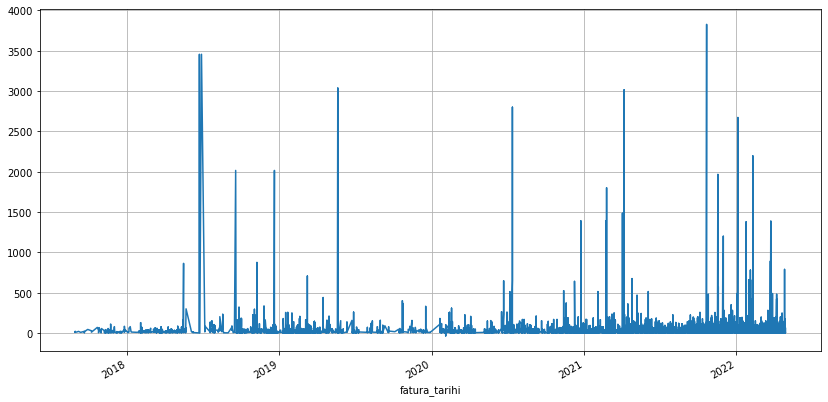

In [74]:
plt.figure(figsize=(14, 7))
combined_daily.ciro.plot(grid=True)
plt.show()

In [75]:
combined_after_2020 = combined_daily['2020':]

In [76]:
combined_after_2020

,Customer,posta_kodu,city,country,COUNTRY NAME,satis_yapilan_platform,satilan_urun,adet,birim_fiyat,enflasyon,ciro,day_of_week,nakliye,category,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,,,,,,,,,,
2020-01-21,ID10007,12168,Neu Berlin,DEU,GERMANY,b2b,10 kg. disar schwarzolive aus gemlik,3.0,36.448598,1.7,109.345794,Tuesday,3.617214,zeytin,1.0,0.0,0.0,1.0
2020-01-21,ID10007,12168,Neu Berlin,DEU,GERMANY,b2b,disar grune oliven-cizik zeytin 10 kg,3.0,41.121495,1.7,123.364486,Tuesday,3.617214,zeytin,1.0,0.0,0.0,1.0
2020-01-21,ID10007,12168,Neu Berlin,DEU,GERMANY,b2b,disar grune oliven-cizik zeytin 10 kg,4.0,45.000000,1.7,180.000000,Tuesday,3.617214,zeytin,1.0,0.0,0.0,1.0
2020-01-21,ID10007,12168,Neu Berlin,DEU,GERMANY,b2b,10 kg. disar schwarzolive aus gemlik,1.0,40.000000,1.7,40.000000,Tuesday,3.617214,zeytin,1.0,0.0,0.0,1.0
2020-01-21,ID10007,12168,Neu Berlin,DEU,GERMANY,b2b,10 kg. disar schwarzolive aus gemlik,4.0,40.000000,1.7,160.000000,Tuesday,3.617214,zeytin,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,IDKundenID3313,1000,other,ATA,ANTARCTICA,wocommerce,dogal findikli muska pestil,1.0,4.210000,7.6,4.210000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0
2022-04-29,IDKundenID3315,1000,other,ATA,ANTARCTICA,wocommerce,dogal findikli muska pestil,1.0,4.200000,7.6,4.200000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0
2022-04-29,IDKundenID7185,1000,other,ATA,ANTARCTICA,wocommerce,gumushane sade ve cevizli dut pestili - 500 gr...,1.0,3.790000,7.6,3.790000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0


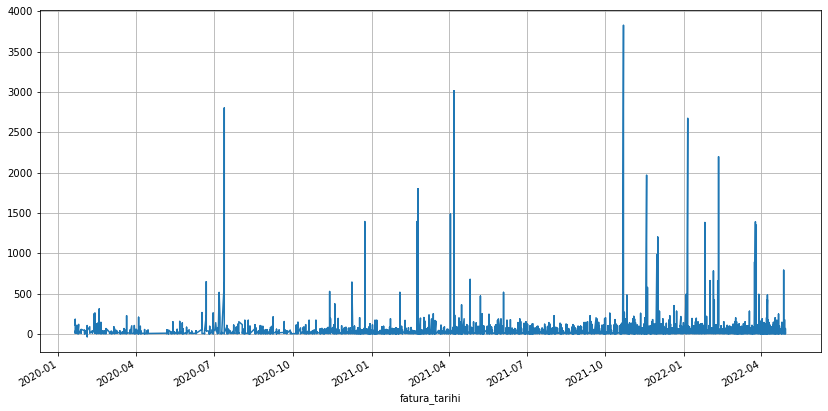

In [77]:
plt.figure(figsize=(14, 7))
combined_after_2020.ciro.plot(grid=True)
plt.show()

In [78]:
combined_2020 = combined_daily['2020']

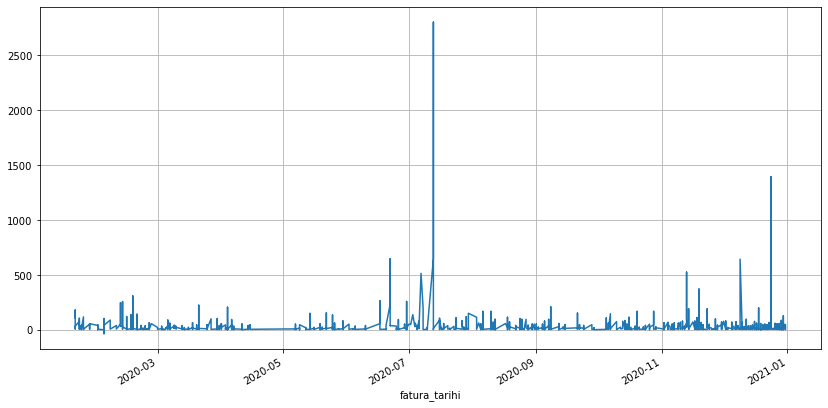

In [79]:
plt.figure(figsize=(14, 7))
combined_2020.ciro.plot(grid=True)
plt.show()

In [80]:
combined_2021 = combined_daily['2021']

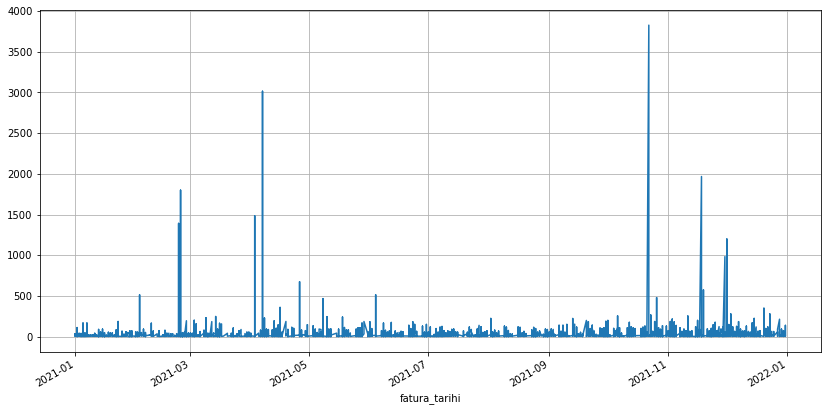

In [81]:
plt.figure(figsize=(14, 7))
combined_2021.ciro.plot(grid=True)
plt.show()

In [82]:
combined_after_2021 = combined_daily['2021':]

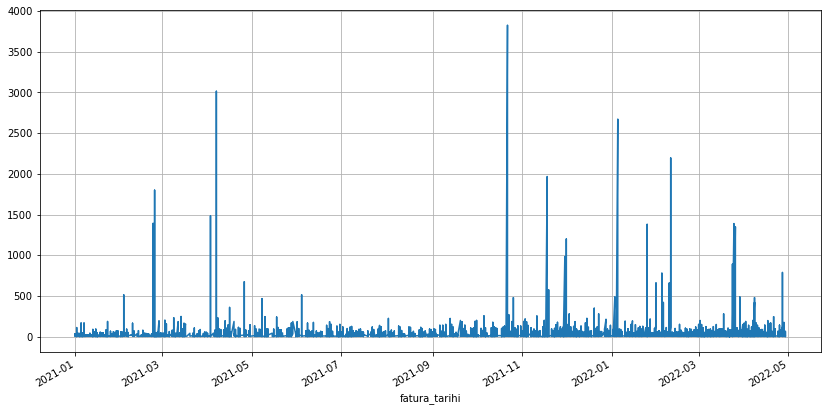

In [83]:
plt.figure(figsize=(14, 7))
combined_after_2021.ciro.plot(grid=True)
plt.show()

**Distribution of Sales in each year**



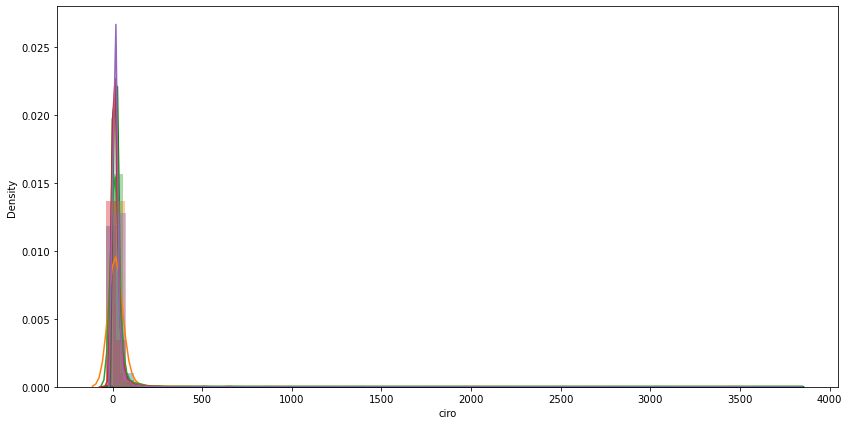

In [84]:
#Distribution plot of each year compared with overall distribution
sns.distplot(combined_daily.ciro,         label='ciro', hist=True, kde_kws={"color": "g", "lw": 3, "label": "Train","shade":True})
sns.distplot(combined_daily['2018'].ciro, label='2018', hist=True)
sns.distplot(combined_daily['2019'].ciro, label='2019', hist=True)
sns.distplot(combined_daily['2020'].ciro, label='2020', hist=True)
sns.distplot(combined_daily['2021'].ciro, label='2021', hist=True);


In [123]:
combined_daily.index

DatetimeIndex(['2017-08-29', '2017-08-29', '2017-08-29', '2017-08-29',
               '2017-09-01', '2017-09-06', '2017-09-11', '2017-09-11',
               '2017-09-20', '2017-09-20',
               ...
               '2022-04-29', '2022-04-29', '2022-04-29', '2022-04-29',
               '2022-04-29', '2022-04-29', '2022-04-29', '2022-04-29',
               '2022-04-29', '2022-04-29'],
              dtype='datetime64[ns]', name='fatura_tarihi', length=39297, freq=None)

In [120]:
#combined_daily.index

In [119]:
#combined_daily = combined_daily.reset_index()

In [115]:
combined_daily

,fatura_tarihi,Customer,posta_kodu,city,country,COUNTRY NAME,satis_yapilan_platform,satilan_urun,adet,birim_fiyat,enflasyon,ciro,day_of_week,nakliye,category,after_covid,before_covid,after_war,before_war
0,2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,almaoliva aove pet 30 ml,20.0,0.500000,1.6,10.000000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
1,2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,almaoliva aove bio marasca 500 ml,10.0,2.000000,1.6,20.000000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2,2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,parqueoliva serie oro aove dop almazaras 500 ml,2.0,4.100000,1.6,8.200000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
3,2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,royal extra 250 ml,10.0,1.300000,1.6,13.000000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
4,2017-09-01,ID10248,45143,Essen,DEU,GERMANY,ebay,bio lavendel honig - direktimport vom bio erze...,1.0,11.682243,1.3,11.682243,Friday,3.617214,bal,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39292,2022-04-29,IDKundenID3313,1000,other,ATA,ANTARCTICA,wocommerce,dogal findikli muska pestil,1.0,4.210000,7.6,4.210000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0
39293,2022-04-29,IDKundenID3315,1000,other,ATA,ANTARCTICA,wocommerce,dogal findikli muska pestil,1.0,4.200000,7.6,4.200000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0
39294,2022-04-29,IDKundenID7185,1000,other,ATA,ANTARCTICA,wocommerce,gumushane sade ve cevizli dut pestili - 500 gr...,1.0,3.790000,7.6,3.790000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0
39295,2022-04-29,IDKundenID7186,1000,other,ATA,ANTARCTICA,wocommerce,gumushane sade ve cevizli dut pestili - 600 gr...,1.0,6.300000,7.6,6.300000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0


In [127]:
combined_daily.columns

Index(['Customer', 'posta_kodu', 'city', 'country', 'COUNTRY NAME',
       'satis_yapilan_platform', 'satilan_urun', 'adet', 'birim_fiyat',
       'enflasyon', 'ciro', 'day_of_week', 'nakliye', 'category',
       'after_covid', 'before_covid', 'after_war', 'before_war'],
      dtype='object')

In [128]:
print (combined_daily.resample('Q').mean().index)


DatetimeIndex(['2017-09-30', '2017-12-31', '2018-03-31', '2018-06-30',
               '2018-09-30', '2018-12-31', '2019-03-31', '2019-06-30',
               '2019-09-30', '2019-12-31', '2020-03-31', '2020-06-30',
               '2020-09-30', '2020-12-31', '2021-03-31', '2021-06-30',
               '2021-09-30', '2021-12-31', '2022-03-31', '2022-06-30'],
              dtype='datetime64[ns]', name='fatura_tarihi', freq='Q-DEC')


In [131]:
from statsmodels.graphics.tsaplots import quarter_plot

In [144]:
combined_daily

,Customer,posta_kodu,city,country,COUNTRY NAME,satis_yapilan_platform,satilan_urun,adet,birim_fiyat,enflasyon,ciro,day_of_week,nakliye,category,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,,,,,,,,,,
2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,almaoliva aove pet 30 ml,20.0,0.500000,1.6,10.000000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,almaoliva aove bio marasca 500 ml,10.0,2.000000,1.6,20.000000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,parqueoliva serie oro aove dop almazaras 500 ml,2.0,4.100000,1.6,8.200000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,royal extra 250 ml,10.0,1.300000,1.6,13.000000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2017-09-01,ID10248,45143,Essen,DEU,GERMANY,ebay,bio lavendel honig - direktimport vom bio erze...,1.0,11.682243,1.3,11.682243,Friday,3.617214,bal,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,IDKundenID3313,1000,other,ATA,ANTARCTICA,wocommerce,dogal findikli muska pestil,1.0,4.210000,7.6,4.210000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0
2022-04-29,IDKundenID3315,1000,other,ATA,ANTARCTICA,wocommerce,dogal findikli muska pestil,1.0,4.200000,7.6,4.200000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0
2022-04-29,IDKundenID7185,1000,other,ATA,ANTARCTICA,wocommerce,gumushane sade ve cevizli dut pestili - 500 gr...,1.0,3.790000,7.6,3.790000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0


In [145]:
combined_daily_q = combined_daily

In [147]:
combined_daily_q

,Customer,posta_kodu,city,country,COUNTRY NAME,satis_yapilan_platform,satilan_urun,adet,birim_fiyat,enflasyon,ciro,day_of_week,nakliye,category,after_covid,before_covid,after_war,before_war
fatura_tarihi,,,,,,,,,,,,,,,,,,
2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,almaoliva aove pet 30 ml,20.0,0.500000,1.6,10.000000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,almaoliva aove bio marasca 500 ml,10.0,2.000000,1.6,20.000000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,parqueoliva serie oro aove dop almazaras 500 ml,2.0,4.100000,1.6,8.200000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2017-08-29,ID -2,1045,Qendra Tregtare TEG,ALB,ALBANIA,b2b,royal extra 250 ml,10.0,1.300000,1.6,13.000000,Tuesday,3.617214,zeytinyagi,0.0,1.0,0.0,1.0
2017-09-01,ID10248,45143,Essen,DEU,GERMANY,ebay,bio lavendel honig - direktimport vom bio erze...,1.0,11.682243,1.3,11.682243,Friday,3.617214,bal,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,IDKundenID3313,1000,other,ATA,ANTARCTICA,wocommerce,dogal findikli muska pestil,1.0,4.210000,7.6,4.210000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0
2022-04-29,IDKundenID3315,1000,other,ATA,ANTARCTICA,wocommerce,dogal findikli muska pestil,1.0,4.200000,7.6,4.200000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0
2022-04-29,IDKundenID7185,1000,other,ATA,ANTARCTICA,wocommerce,gumushane sade ve cevizli dut pestili - 500 gr...,1.0,3.790000,7.6,3.790000,Friday,0.000000,pestil,1.0,0.0,1.0,0.0


In [148]:
combined_daily_q.resample('Q').mean().index

DatetimeIndex(['2017-09-30', '2017-12-31', '2018-03-31', '2018-06-30',
               '2018-09-30', '2018-12-31', '2019-03-31', '2019-06-30',
               '2019-09-30', '2019-12-31', '2020-03-31', '2020-06-30',
               '2020-09-30', '2020-12-31', '2021-03-31', '2021-06-30',
               '2021-09-30', '2021-12-31', '2022-03-31', '2022-06-30'],
              dtype='datetime64[ns]', name='fatura_tarihi', freq='Q-DEC')

In [152]:
combined_daily_q= combined_daily_q.resample('Q').mean()

In [153]:
combined_daily_q.index

DatetimeIndex(['2017-09-30', '2017-12-31', '2018-03-31', '2018-06-30',
               '2018-09-30', '2018-12-31', '2019-03-31', '2019-06-30',
               '2019-09-30', '2019-12-31', '2020-03-31', '2020-06-30',
               '2020-09-30', '2020-12-31', '2021-03-31', '2021-06-30',
               '2021-09-30', '2021-12-31', '2022-03-31', '2022-06-30'],
              dtype='datetime64[ns]', name='fatura_tarihi', freq='Q-DEC')

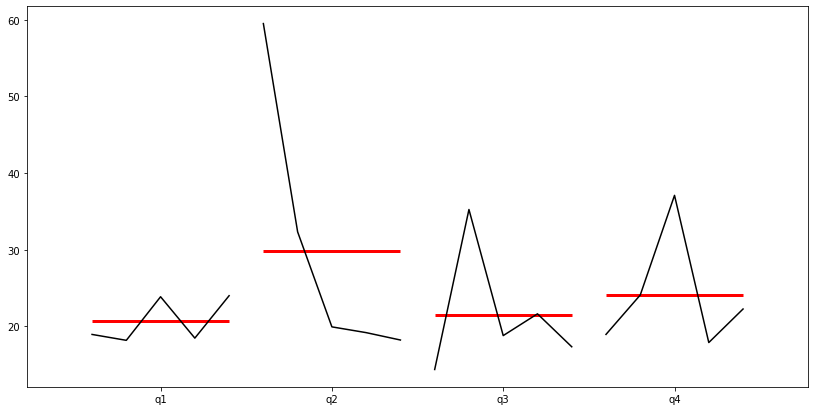

In [185]:
#Quarterly plot: Shows trend for Q1-Q4 for each of the years. Red line shows mean
quarter_plot(combined_daily_q[['ciro']]);

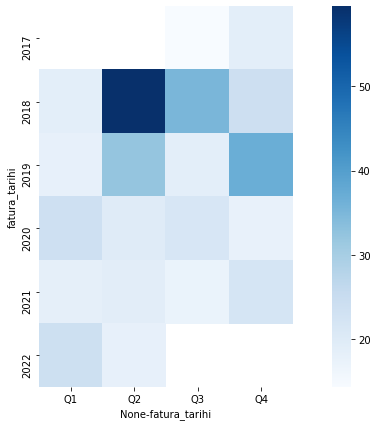

In [184]:
#collapse-hide
sns.heatmap(pd.pivot_table(data=combined_daily[['ciro']], index=combined_daily.index.year, columns=combined_daily.index.quarter),
           square=True,
           cmap='Blues',
           xticklabels=["Q1", "Q2", "Q3", "Q4"]);


In [164]:
stack1= alt.Chart(combined_daily[:'2021'].reset_index()).mark_bar().encode(
    x=alt.X('sum(Sales)'),
    y='year(Date):N',
    color=alt.Color(
        'quarter(Date)',
        scale=alt.Scale(scheme='category10')),
    tooltip=["Date", "Sales"]).properties(
    height=100, 
    width = 300, 
    title = "Sum of Sales by each Quarter")
    
stack2= alt.Chart(combined_daily[:'2021'].reset_index()).mark_bar().encode(
    x=alt.X('sum(Sales)', stack='normalize'),
    y='year(Date):N',
    color=alt.Color(
        'quarter(Date)', 
        scale=alt.Scale(scheme='category10')),
    tooltip=["Date", "Sales"]
    ).properties(
    height=100, 
    width = 300, 
    title = "Sum of Sales as % by each Quarter")



stack1 | stack2


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.HConcatChart(...)

In [85]:
import altair as alt

In [182]:
combined_daily[['ciro']] #, combined_daily.ciro]

,ciro
fatura_tarihi,
2017-08-29,10.000000
2017-08-29,20.000000
2017-08-29,8.200000
2017-08-29,13.000000
2017-09-01,11.682243
...,...
2022-04-29,4.210000
2022-04-29,4.200000
2022-04-29,3.790000


In [158]:
alt.Chart(combined_after_2021.reset_index()).mark_line(point=True).encode(
    x=combined_daily.index.date, 
    y='ciro',
    column=combined_daily.index.year,
    tooltip=['fatura_tarihi', 'ciro']).properties(
    title="Sales: Yearly Subseries plot",
    width=100).configure_header(
    titleColor='black',
    titleFontSize=14,
    labelColor='blue',
    labelFontSize=14
)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

**Seasonality Factor**

This will help us understand how much each quarter contributes relative to the average demand. Note that this should be done on a de-trended series(taking first difference) but because we don't have enough data and for a quick demonstration, I am using the series as is.



In [183]:
#Groupby Sales by Quarter

#Only use upto 2015 because we have partial data for 2016
#train_2015=train[:'2015']
avg_combined= np.int(combined_daily.ciro.mean())

#Avg sales per quarter
qrt_avg=combined_daily.groupby(combined_daily.index.quarter)["ciro"].mean()

#Groupby quarter
qrt_table = pd.pivot_table(combined_daily[['ciro']], index=combined_daily.index.quarter, columns=combined_daily.index.year)

#add qrt_avg to qrt_table
qrt_table["avg"] = qrt_avg

#Additive Seasonality Factor: Subtract mean from avg column
qrt_table["additive"] = qrt_table["avg"]-avg_combined

#Multiplicative Seasonality Factor: Subtract mean from avg column
qrt_table["multiplicative"] = (qrt_table["avg"]/avg_combined).round(2)

qrt_table.index.name="Quarters"

qrt_table

	

ciro                                              \
fatura_tarihi       2017       2018       2019       2020       2021   
Quarters                                                               
1                    NaN  18.936449  18.166629  23.851585  18.455808   
2                    NaN  59.480702  32.315438  19.923304  19.170949   
3              14.361957  35.229809  18.783866  21.622723  17.326870   
4              18.939475  24.077316  37.075860  17.877570  22.253409   

                                avg  additive multiplicative  
fatura_tarihi       2022                                      
Quarters                                                      
1              23.987467  21.865516  1.865516           1.09  
2              18.207598  20.126391  0.126391           1.01  
3                    NaN  18.673909 -1.326091           0.93  
4                    NaN  21.566538  1.566538           1.08

**Decomposition**

We will de-compose the time series into trend, seasonal and residuals

additive is prefferred when seasonal variation is constant. multiplicative is preferred when it is increasing.

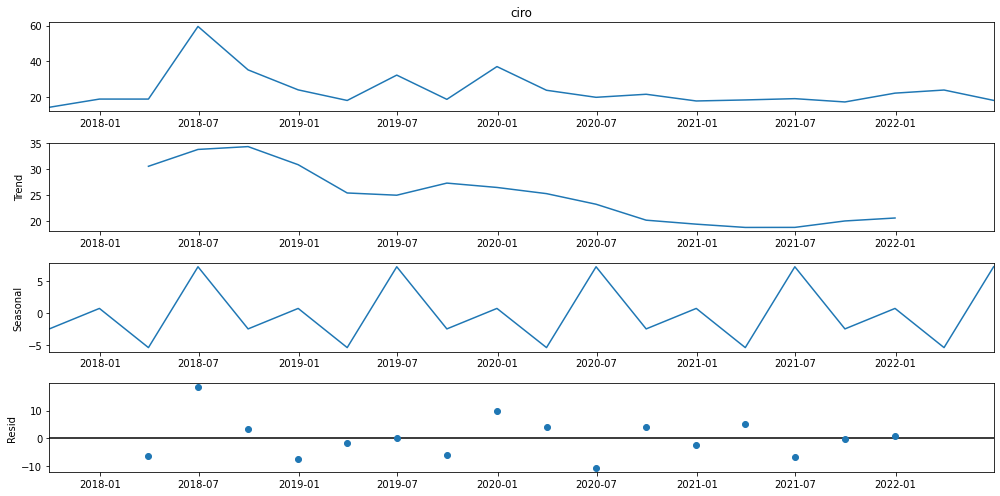

In [187]:
decomposition = sm.tsa.seasonal_decompose(combined_daily_q.ciro, model = 'additive') 
fig = decomposition.plot();
fig.set_size_inches(14,7)
plt.show()

**Observations:**

 - Trend is more than linear,  notice that trend is projecting downward.
 - Seasonal pattern is somehow consistent
 - Resduals are whatever is left after fitting the trend and seasonal components to the observed data. It's the component we cannot explain. We want the residuals to be i.i.d (i.e uncorrelated). If the residuals have a pattern, it means there is still some structural information left to be captured. Residuals are showing some wavy pattern, which is not good. Let's perform Ljung Box test to confirm if they are i.i.d as a group.
 - We do not want to see any recognizable patterns in the residuals, e.g. waves, upward/downward slope, funnel pattern etc. 
    

In [189]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung

In [191]:
ljung_p = np.mean(ljung(x=decomposition.resid.dropna())[1]).round(3)
print("Ljung Box, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")


Ljung Box, p value: 0.429 , Residuals are uncorrelated


Residuals are uncorrelated. If the residuals are correlated, we can perform transformations to see if it stabilizes the variance. It's also an indication that we may need to use exogenous variable to fully explain the time series behaviour or use higher order models. In this case, the residuals are uncorrelated so that's good.

**Second Order Properties of the time series**

We study the second order properties to understand -

    is the data stationary
    is the data white noise, random walk? i.e are the lags correlated?
    quantify seasonal/cyclic behviour

Stationarity:

For the series to be stationary, it must have:

    constant mean
    constant variance
    constant covariance (uncorrelated)

We verify this by observing change in mean, variance, autocorrelation and with a statistical test (ADFuller test)


**Is the mean constant?**

Mean is: 20.638403399193994


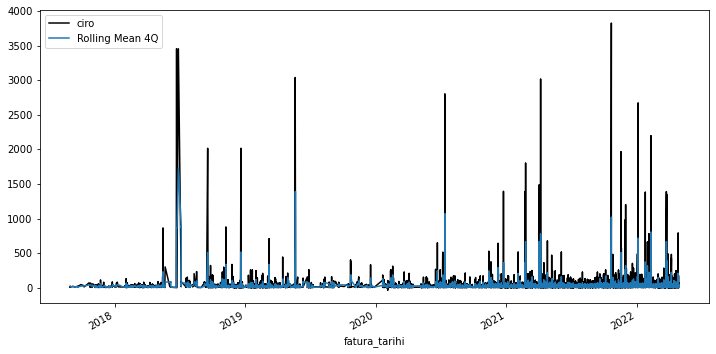

In [192]:
combined_daily[['ciro']].plot(figsize=(12,6), legend=True, label="combined daily", cmap='gray')
combined_daily["ciro"].rolling(4, center=False).mean().plot(legend=True, label="Rolling Mean 4Q");
print("Mean is:", combined_daily["ciro"].mean())


**Is the variance constant?**

S.D is: 61.9179771846464


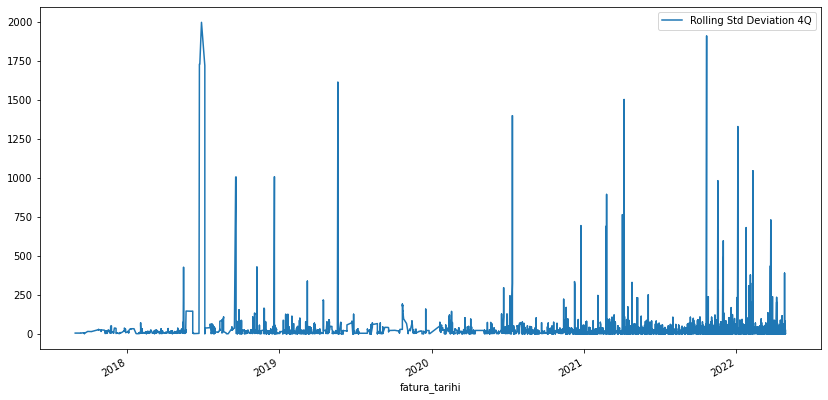

In [194]:
combined_daily["ciro"].rolling(4).std().plot(legend=True, label="Rolling Std Deviation 4Q");
print("S.D is:", combined_daily["ciro"].std())

**Coefficient of Variation:**

Coefficient of variation gives us an idea about the variability in the process, especially when looking at sales and demand. Note that this should be used for relative comparison and does not have a strict statistical defition. It's very common measure in demand planning and inventory analytics.

c.v = s.d/mean

If C.V<0.75 => Low Variability

If 0.75<C.V<1.3 => Medium Variability

If C.V>1.3 => High Variability

In [196]:
cv = combined_daily["ciro"].std()/combined_daily["ciro"].mean()
cv

3.0001340698217254

This is a high-variability process.

**Check for stationarity** <a id="88"></a>  [^](#Up)<br>

Augmented Dicky Fuller test is a statistical test for stionarity. If the p value is less than 0.05, the series is stationary, otherwise non-stationary. Use adfuller() from statsmodels

In [87]:
adf_test = combined_daily.ciro
adf_test = adf_test.dropna()
results = adfuller(adf_test)
print("The ADF p-valu is %4.4f" %(results[1]))

The ADF p-valu is 0.0000


smaller than 0.05 so it is stationary.

In [88]:
#Calculate ad fuller statistic
adf = adfuller(combined_daily.ciro)[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.0 , Series is Stationary


**Draw the autocorrelation  and partial autocorrelation graphs** <a id="84"></a>  [^](#T)<br>

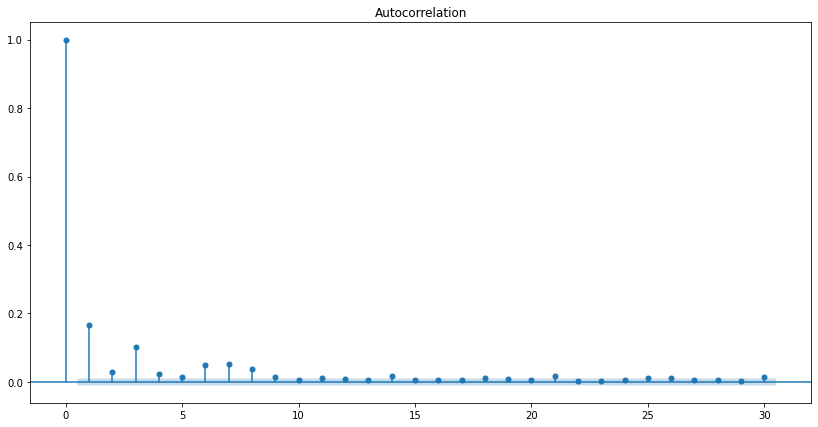

In [89]:
plot_acf(combined_daily.ciro.dropna(), alpha=0.05, lags=30)
plt.show()

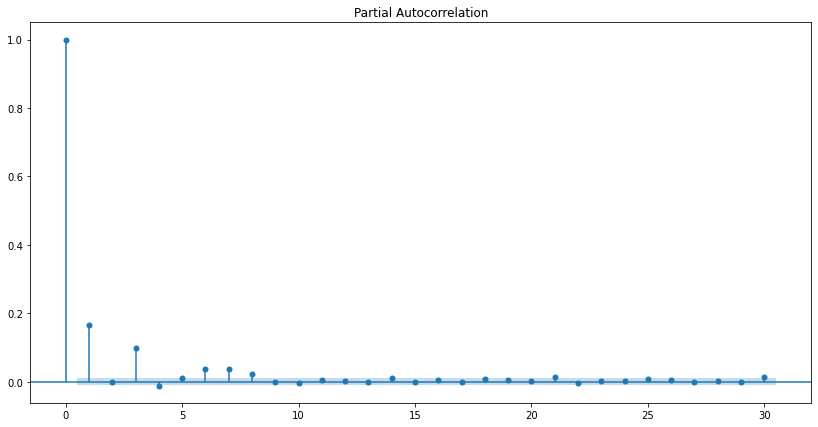

In [90]:
plot_pacf(combined_daily.ciro.dropna(), alpha=0.05, lags=30)
plt.show()

**Grid Search Over Parameters** <a id="85"></a>  [^](#T)<br>

In [91]:
search_data = combined_daily.ciro.dropna()
search_data_d = 1
order_aic_bic =[]
# Loop over AR order
for p in range(4):
    # Loop over MA order
    for q in range(4):
        # Fit model
        model = SARIMAX(search_data, order=(p,search_data_d,q))
        results = model.fit()
        # Add order and scores to list
        order_aic_bic.append((p, q, results.aic, results.bic))
        
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'AIC', 'BIC'])
print("Model order and AIC/BIC score (Sorted by AIC):\n", order_df.sort_values(by=['AIC', 'BIC']))
print("\nModel order and AIC/BIC score (Sorted by BIC):\n", order_df.sort_values(by=['BIC', 'AIC']))

Model order and AIC/BIC score (Sorted by AIC):
     p  q            AIC            BIC
14  3  2  434254.271851  434305.745119
15  3  3  434258.117400  434318.169547
13  3  1  434259.307993  434302.202383
11  2  3  434276.421969  434327.895237
10  2  2  434517.452079  434560.346469
7   1  3  434545.997367  434588.891757
6   1  2  434592.011694  434626.327206
3   0  3  434614.519036  434648.834548
2   0  2  434615.524468  434641.261102
5   1  1  434628.426833  434654.163467
9   2  1  434630.055809  434664.371321
1   0  1  435599.670222  435616.827978
12  3  0  441388.669112  441422.984624
8   2  0  442755.019241  442780.755875
4   1  0  448340.986913  448358.144669
0   0  0  455833.172803  455841.751681

Model order and AIC/BIC score (Sorted by BIC):
     p  q            AIC            BIC
13  3  1  434259.307993  434302.202383
14  3  2  434254.271851  434305.745119
15  3  3  434258.117400  434318.169547
11  2  3  434276.421969  434327.895237
10  2  2  434517.452079  434560.346469
7   1 

                               SARIMAX Results                                
Dep. Variable:                   ciro   No. Observations:                39297
Model:               SARIMAX(3, 0, 2)   Log Likelihood             -217262.086
Date:                Wed, 31 Aug 2022   AIC                         434536.172
Time:                        13:17:00   BIC                         434587.646
Sample:                             0   HQIC                        434552.479
                              - 39297                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4222      0.019     22.330      0.000       0.385       0.459
ar.L2          0.6636      0.023     28.758      0.000       0.618       0.709
ar.L3         -0.0861      0.004    -20.377      0.0

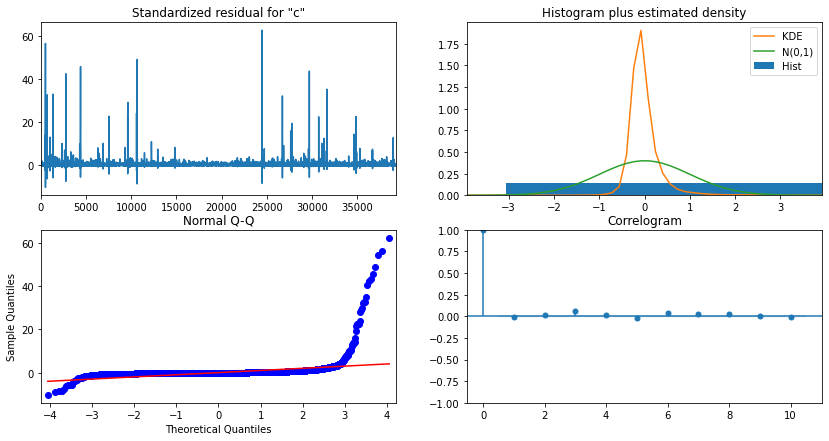

In [92]:
#we try first one p=3,q=2, diff=0
arima_data = combined_daily.ciro
arima = SARIMAX(arima_data, order=(3,0,2)) 

# Fit ARIMA model
arima_results = arima.fit()
print(arima_results.summary())

# Make ARIMA forecast of next 10 values
arima_value_forecast = arima_results.get_forecast(steps=10).predicted_mean

# Print forecast
print(arima_value_forecast)

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

# Create the 4 diagostics plots
arima_results.plot_diagnostics()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                   ciro   No. Observations:                39306
Model:               SARIMAX(3, 0, 3)   Log Likelihood             -246713.419
Date:                Tue, 30 Aug 2022   AIC                         493440.838
Time:                        02:30:35   BIC                         493500.892
Sample:                             0   HQIC                        493459.863
                              - 39306                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3234      0.001    222.407      0.000       0.321       0.326
ar.L2          0.9995      0.001   1470.680      0.000       0.998       1.001
ar.L3         -0.3229      0.001   -230.320      0.0

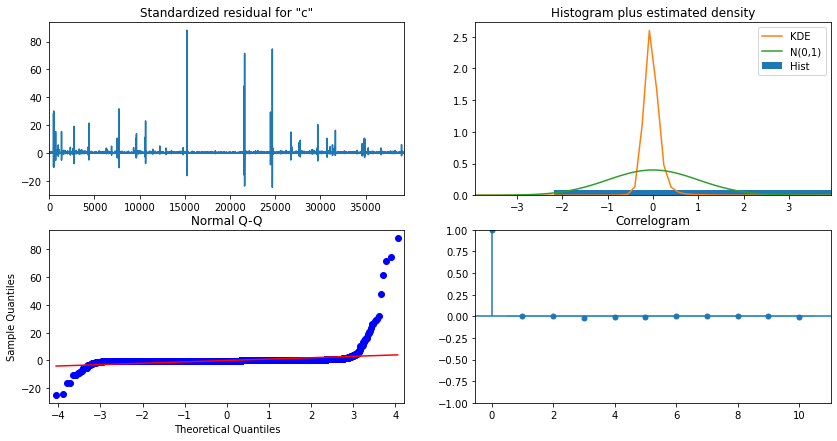

In [31]:
#we try first one p=1,q=1, diff=0
arima_data = combined_daily
arima = SARIMAX(arima_data, order=(3,0,3)) 

# Fit ARIMA model
arima_results = arima.fit()
print(arima_results.summary())

# Make ARIMA forecast of next 10 values
arima_value_forecast = arima_results.get_forecast(steps=10).predicted_mean

# Print forecast
print(arima_value_forecast)

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print("Mean Absolute Error (MAE): %4.2f" %(mae))

# Create the 4 diagostics plots
arima_results.plot_diagnostics()
plt.show()

In [ ]:
# Create auto_arima model
pm_model = pm.auto_arima(combined_daily,
                    trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                        seasonal=True, m=7)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=493415.119, Time=36.40 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=497954.702, Time=2.64 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=493418.445, Time=7.02 sec


**Which frequencies are prominent?**

We typically look at the time series in the time domain. But, we can also analyze the time series in the frequency domain. It's based on the assumption that it is made up of sine and cosine waves of different frequencies. This helps us detect periodic component of known/unknown frequencies. It can show additional details of the time series that can be easily missed. We do it with a Periodogram and Power Spectral Density plot.

Periodogram: We analyze frequency and associated intensity of frequency. Note that below I have invrted the frequency to obtain periods Period,T = 1/frequency. For example, a monthly time series has 12 seasonal periods, so we would obtain frequency = 1/12 = 0.0833. In our example, we expect to see the intensity to be high at period=4



In [200]:
from scipy import signal   

In [201]:
def plot_pgram(series,diff_order):
    """
    This function plots thd Power Spectral Density of a de-trended series. 
    PSD should also be calculated for a de-trended time series. Enter the order of differencing needed
    Output is a plot with PSD on Y and Time period on X axis
    
    Series: Pandas time series or np array
    differencing_order: int. Typically 1
    
    """
    #from scipy import signal    
    de_trended = series.diff(diff_order).dropna()
    f, fx = signal.periodogram(de_trended)
    freq=f.reshape(len(f),1) #reshape the array to a column
    psd = fx.reshape(len(f),1)
#     plt.figure(figsize=(5, 4)
    plt.plot(1/freq, psd  )
    plt.title("Periodogram")
    plt.xlabel("Time Period")
    plt.ylabel("Amplitude")
    plt.tight_layout()

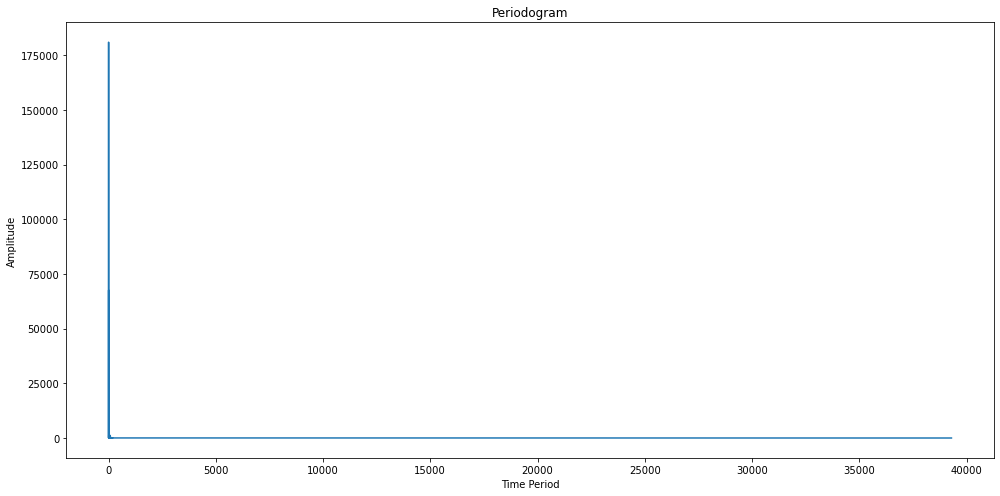

In [202]:
plot_pgram(combined_daily['ciro'],1);


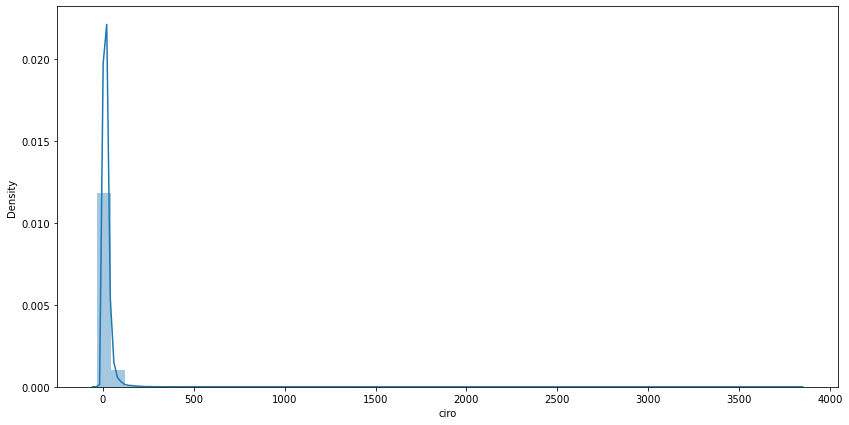

In [203]:
#Distribution Plot
sns.distplot(combined_daily['ciro']);


In [205]:
import statsmodels.api as sm

In [206]:
#Q-Q Plot
sm.qqplot(combined_daily['ciro'], fit=True, line='45', alpha=0.5, dist='norm' );


AttributeError: 'str' object has no attribute 'fit'

In [207]:
#Jarque Bera Stastical Test for Normality
from scipy.stats import jarque_bera as jb
is_norm=jb(combined_daily['ciro'])[1]
print(f"p value:{is_norm.round(2)}", ", Series is Normal" if is_norm >0.05 else ", Series is Non-Normal")


p value:0.0 , Series is Non-Normal
